In [1]:
!pip install transformers

In [2]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchtext
import json
import random
import os
from scipy import interpolate
import re

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data

In [ ]:
!unzip wikipedia_data_v2.zip

In [4]:
!unzip wikipedia_data_v3.zip

Archive:  wikipedia_data_v3.zip
   creating: wikipedia_data_v3/(What_Is)_Love_/
   creating: wikipedia_data_v3/(What_Is)_Love_/img/
  inflating: wikipedia_data_v3/(What_Is)_Love_/img/meta.json  
  inflating: wikipedia_data_v3/(What_Is)_Love_/text.json  
   creating: wikipedia_data_v3/2015_Tour_de_France/
   creating: wikipedia_data_v3/2015_Tour_de_France/img/
  inflating: wikipedia_data_v3/2015_Tour_de_France/img/meta.json  
  inflating: wikipedia_data_v3/2015_Tour_de_France/text.json  
   creating: wikipedia_data_v3/7_Subway_Extension/
   creating: wikipedia_data_v3/7_Subway_Extension/img/
  inflating: wikipedia_data_v3/7_Subway_Extension/img/meta.json  
  inflating: wikipedia_data_v3/7_Subway_Extension/text.json  
   creating: wikipedia_data_v3/A.I._Artificial_Intelligence/
   creating: wikipedia_data_v3/A.I._Artificial_Intelligence/img/
  inflating: wikipedia_data_v3/A.I._Artificial_Intelligence/img/meta.json  
  inflating: wikipedia_data_v3/A.I._Artificial_Intelligence/text.json  


In [5]:
def extract_text(folder_name):
  folder_names = os.listdir(folder_name)
  # put all text in a list
  text = []
  for folder in folder_names:
    with open(folder_name + '/' + folder + '/text.json') as file:
      file_content = file.read()
      file_content_str = json.loads(file_content)
      # need to convert the file content to a dict to extract text
      file_content_dict = json.loads(file_content_str)
      text.append(file_content_dict["text"])
  return text

In [ ]:
text2 = extract_text('wikipedia_data_v2')

In [6]:
text = extract_text('wikipedia_data_v3')

In [7]:
folder_names = os.listdir("wikipedia_data_v3")
folder_names.index("Agriculture")

25

In [8]:
text[25] = text[25].replace('\nthumb |upright=1.35 |Centres of origin, as numbered by Nikolai Vavilov in the 1930s. Area 3 (gray) is no longer recognised as a centre of origin, and Papua New Guinea (area P, orange) was identified more recently.\n', '')

In [9]:
def preprocess_text(text):
  text_prepros = []
  for ex in text:
    new1 = re.sub('\n.+\|thumb.*\n?(.*)?', '', ex)
    new2 = re.sub('\n?(.*)?\|thumb.*\n', '', new1)
    new3 = re.sub('\n.+thumb\|.*\n?(.*)?', '', new2)
    new4 = re.sub('\n?(.*)?thumb\|.*\n', '', new3)
    new5 = re.sub('\n.+\|thumbnail.*\n?(.*)?', '', new4)
    new6 = re.sub('\n?(.*)?\|thumbnail.*\n', '', new5)
    new7 = re.sub('\n.+thumbnail\|.*\n?(.*)?', '', new6)
    new8 = re.sub('\n?(.*)?thumbnail\|.*\n', '', new7)
    text_prepros.append(new8)
  return text_prepros

In [10]:
text_clean = preprocess_text(text)

Text(0.5, 1.0, 'Effect of preprocessing on text length')

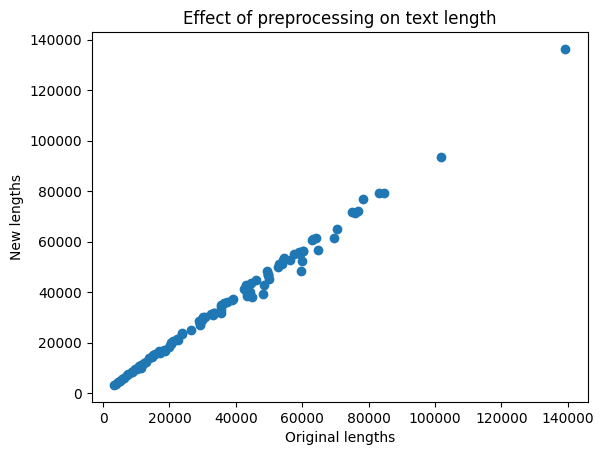

In [11]:
len_orig = [len(i) for i in text]
len_preproc = [len(i) for i in text_clean]

plt.scatter(len_orig, len_preproc)
plt.xlabel("Original lengths")
plt.ylabel("New lengths")
plt.title("Effect of preprocessing on text length")

### Tokenizers and Models

In [ ]:
tokenizergpt2 = GPT2Tokenizer.from_pretrained("gpt2")
tokenizergpt2.padding_side = "left"
tokenizergpt2.pad_token = tokenizergpt2.eos_token

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
modelgpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
modelgpt2.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
tokenizergpt2(tokenizergpt2.eos_token)

{'input_ids': [50256], 'attention_mask': [1]}

In [ ]:
tokenizergpt2.eos_token

'<|endoftext|>'

In [ ]:
tokenizergpt2_large = GPT2Tokenizer.from_pretrained("gpt2-xl")
tokenizergpt2_large.padding_side = "left"
tokenizergpt2_large.pad_token = tokenizergpt2_large.eos_token

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

In [ ]:
all_possible_tokens = list(tokenizergpt2_large.get_vocab().keys())
print(all_possible_tokens)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'Ā', 'ā', 'Ă', 'ă', 'Ą', 'ą', 'Ć', 'ć', 'Ĉ', 'ĉ', 'Ċ', 'ċ'

In [ ]:
modelgpt2_large = GPT2LMHeadModel.from_pretrained("gpt2-xl")
modelgpt2_large.to(device)

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

### Functions

In [ ]:
# encode all the text
def encode(text, tokenizer):
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=1001)
  #inputs.to(device);
  # remove examples that don't have a 1000 tokens
  long_enough_rows = torch.nonzero(inputs["input_ids"][:, 0] != 50256).squeeze()
  input_ids = inputs["input_ids"][long_enough_rows]
  attention_mask = inputs["attention_mask"][long_enough_rows]
  return input_ids, attention_mask

In [ ]:
def measure_accuracy(input_ids, attention_mask, model, context_lengths, batch_size, file_name, top_x=1):
  # construct contexts and run batch generation
  # key is context length, value is the accuracy (number of correct next token predictions divided by number of examples)
  output_dict = {}
  for c in context_lengths:
    output_dict[c] = 0
    if c >= 100:
      batch_size_to_use=2
    else:
      batch_size_to_use=batch_size
    print(batch_size_to_use)
    for b in range(0, input_ids.size()[0], batch_size_to_use):
      # get the last batch
      if b > input_ids.size()[0]:
        input_ids_curr = input_ids[b-batch_size_to_use:, 0:c]
        attention_mask_curr = attention_mask[b-batch_size_to_use:, 0:c]
        correct_tokens = input_ids[b-batch_size_to_use:, c]
      else:
        input_ids_curr = input_ids[b:b+batch_size_to_use, 0:c]
        attention_mask_curr = attention_mask[b:b+batch_size_to_use, 0:c]
        correct_tokens = input_ids[b:b+batch_size_to_use, c]

      input_ids_curr = input_ids_curr.to(device);
      attention_mask_curr = attention_mask_curr.to(device);
      correct_tokens = correct_tokens.to(device);
      with torch.inference_mode():
        pred = model.generate(input_ids=input_ids_curr, attention_mask=attention_mask_curr, do_sample=False, max_new_tokens=1, pad_token_id=50256, output_scores=True, return_dict_in_generate=True)
      # get logits and softmax
      probs = torch.softmax(pred.scores[0], dim=-1)
      # get the top x tokens based on probability
      top_values, top_ind = torch.topk(probs, k=top_x)
      # with torch.inference_mode():
      #   pred = model.generate(input_ids=input_ids_curr, attention_mask=attention_mask_curr, do_sample=False, max_new_tokens=1, pad_token_id=50256)
      # predicted_tokens = pred[:, -1]
      # accuracy = torch.eq(predicted_tokens, correct_tokens).sum().item()
      accuracy = torch.any(top_ind==correct_tokens.view(-1, 1), dim=1).sum().item()
      output_dict[c] += accuracy

    output_dict[c] = output_dict[c]/input_ids.size()[0]

  with open(file_name, "w") as file:
    json.dump(output_dict, file)
  return output_dict

### Data Analysis for GPT-2 x-large

In [ ]:
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)

In [ ]:
input_ids.shape

torch.Size([100, 1001])

In [ ]:
truncated_text = []
for ex in input_ids:
  truncated_text.append(''.join([tokenizergpt2_large.decode(token) for token in ex]))

In [ ]:
all_data = pd.DataFrame({'text': truncated_text})
all_data.to_csv("data_final.csv")

In [ ]:
for t in range(0, len(truncated_text)):
  if "thumb" in truncated_text[t]:
    print(t)

# these articles actually have the word thumb in it or it is part of a word

44
87


In [ ]:
# there is a drop at 600: what are the two tokens?
for ex in input_ids:
  print(tokenizergpt2_large.decode(ex[599]) + tokenizergpt2_large.decode(ex[600]))

 very well
 renamed it
 mm
o lobby
D),
 However,
root juice
, prom
 Eritre
 at which
itors and
, and
choa
UCN
  Episode
. Page
 loves,
 inheritance preceded
 occl
 book in
 through metallic
 this.
 I'll
 Before introducing
 lentils
iter and
ia,
, Beer
: Oxford
 frenzy,
 as selection
 the spinal
 (June
 rights,
able errors
 examples,
 year,
a).
 the University
 thinkers,
 when the
. Curtis
 ever lived
: E
 of Ireland
moved
's first
 efforts of
 that bacterial
-down
 fish in
 1925 Hastings
 of their
 Louise and
 In various
 "no
 there was
 Because 3
 The economy
archari
ign Highway
 the stadium
 the atmosphere
 the mar
 proprietary network
s a
 grant.
 their property
 the idea
 first,
 return David
 made during
 important purposes
 anchorages
, Cr
 Hippob
elom
-8



. Within
1753
 in the
. 
 bond;
 derived from
 March 25
 which is
 be symm
), is
 oases
 cause of
 typically considered
 conflict with
 She therefore
, Ang
 composed of
. Chinese
 the dominance
 section,
a,


In [ ]:
# there is a drop at 600: what are the two tokens?
for ex in input_ids:
  print(tokenizergpt2_large.decode(ex[590]) + tokenizergpt2_large.decode(ex[610]))

 as payment
 only the
  the
 Ten,
es ap
 the problem
 beet components
, such
 had Mer
 City.
ro as
 approach attributed
 into Prize
 the is
E February
 Saudi of
 her pet
 de the
,1
. 21
 whichs
 synthesis extensively
 the."
 1970 designated
ornax
k two
 research particular
 ancient Love
 Progressive.
 bleed but
 over as
 lower spinal
 Mysteries vol
 education global
 The one
's animals
 ( e
 age the
 location

 F.
. England
 thereforeole
, Early
 itag
01 the
ς�
 accounting During
 Bronx University
 wherever by
ish (
 as in
 other a
 objectsysics
 reserve.
 the TNT
 was version
 could enormous
 does of
 ranks.
oyas
 a to
 Fields

energy called

 C
  World
ft their
H000
 both,
 toCommercial
 ofoke
 drown way
 and weak
 habitat chest
 between of
. 
 names second
 Platic
 in deliveries
 affectedamin
 the,
a plant
inations term
 gave genus
 and,
cut words
 blossStaff
 New

 or the
 the Ac
ocks life
 system

 unexpected According
 that the
." the
 attack a
 baseballbat
ini merit
 Thethat
ind

In [ ]:
# there is a peak at 100: what are the two tokens?
for ex in input_ids:
  print(tokenizergpt2_large.decode(ex[99]) + tokenizergpt2_large.decode(ex[100]))

 behind only
 Boston,
 producing districts
 the World
 by a
 Anna is
cht and
,557
ana and
 City borough
 special adaptations

The



 elephants have
 co-
 raw materials
 Jonathan Freeman
a plants
culata
The rock
, and
 "e
 widespread popularity
 which shared
 Plants were
 earnings for
, and
 Wiley 2013
osmith
 Marlin
rytis
 descriptions of
 work,
ised and
 and can
 examples are
The bald
 the moth
 of the
 think tank
 set of
 older specimen
 Dragonflies
, provides
 and the
 for the
 corporate collapses
 eminent scientists
 of the
 are up
 tetrap
 players.
mology is
 located to
 BlackBerry 10
 Diana "
purpose alloc
 and determine
 area of
 blacktip
.

on was
 reduced Plan
 grasses
ysics.
 the North
 and hundreds
 have their
 cryptographic key
water fish
-climate
.

 found in
 Brooklyn Bridge
 operates 6
 is a
ilaterians
 Jet Age
 and buoy
 known forms
 or o
 along with
 Himalaya
, and
like structure
 hubs,
 remot
 Australian C
. In
 that falls
  The
giea
 considered the
 obtainable
 prod

### Experiments

Experiments:
- GPT-2 small, 45 ex, 25 context length
- GPT-2 x-large, 45 ex, 25 context length
- GPT-2 small, 45 ex, 33 context length
- GPT-2 x-large, 45 ex, 33 context length
- GPT-2 small, 75 ex, 33 context length
- GPT-2 x-large, 75 ex, 33 context length
- GPT-2 small, 100 ex (preprocessed), 33 context length, top-2
- GPT-2 x-large, 100 ex (preprocessed), 33 context length, top-2
- GPT-2 x-large, 100 ex (preprocessed), 33 context length, top-3
- GPT-2 x-large, 100 ex (preprocessed), 33 context length, top-4

Notes:

data_v1: 49 examples

data_v2: 75 examples

data_v3: 100 examples

cl_v1: context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000]

cl_v2: context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]


In [ ]:
def plot(output_filename, label_line):
  # plot
  with open(output_filename) as f:
    content = f.read()
  acc = json.loads(content)
  #x = np.array(list(acc), dtype='float64')
  x = list(acc)
  y = np.array(list(acc.values()), dtype='float64')
  #m, b = np.polyfit(np.log10(x), y, 1)
  plt.figure(figsize=(11, 5))
  plt.plot(x, y, label=label_line)
  plt.xticks(rotation = 25)
  #plt.plot(x, m*np.log10(x) + b, label="Line of best fit", linewidth=0.7, color='purple')
  #plt.xscale('log')
  plt.legend()
  plt.xlabel("Context length")
  plt.ylabel("Accuracy")
  plt.title("Average accuracy as a function of context length")
  plt.show()

##### GPT-2 small, 25 context lengths, 49 examples

In [ ]:
input_ids, attention_mask = encode(text=text, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_datav1_clv1.json")

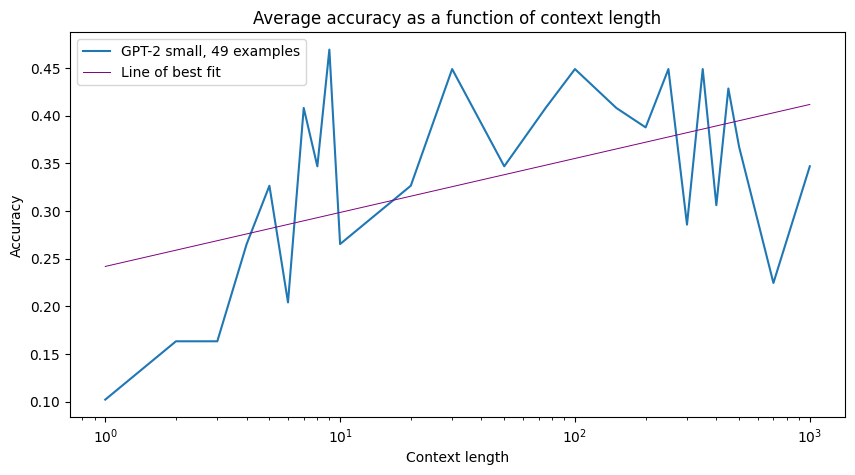

In [ ]:
plot(output_filename="gpt2small_datav1_clv1.json", label_line='GPT-2 small, 49 examples')

##### GPT-2 x-large, 25 context lengths, 49 examples

In [ ]:
input_ids, attention_mask = encode(text=text, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_datav1_clv1.json")

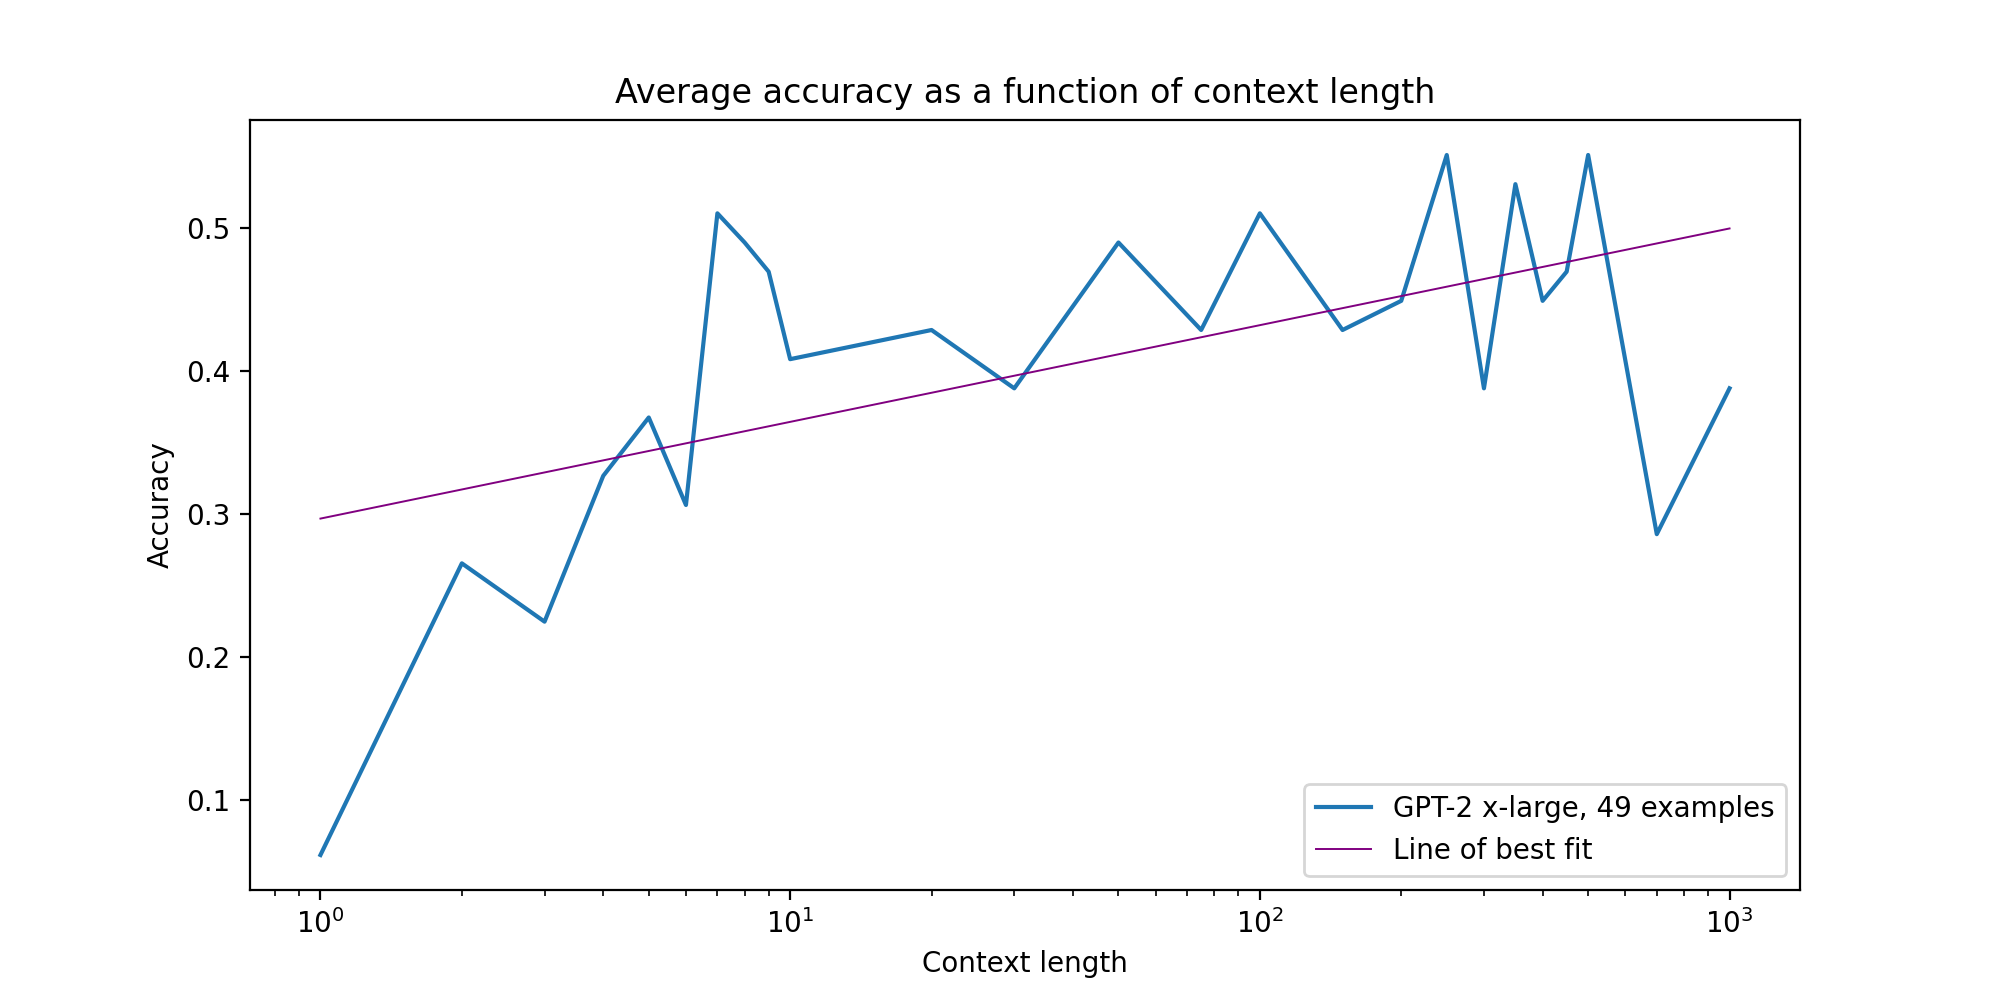

In [ ]:
plot(output_filename="gpt2large_datav1_clv1.json", label_line='GPT-2 x-large, 49 examples')

##### GPT-2 small, 33 context lengths, 49 examples

In [ ]:
input_ids, attention_mask = encode(text=text, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_datav1_clv2.json")

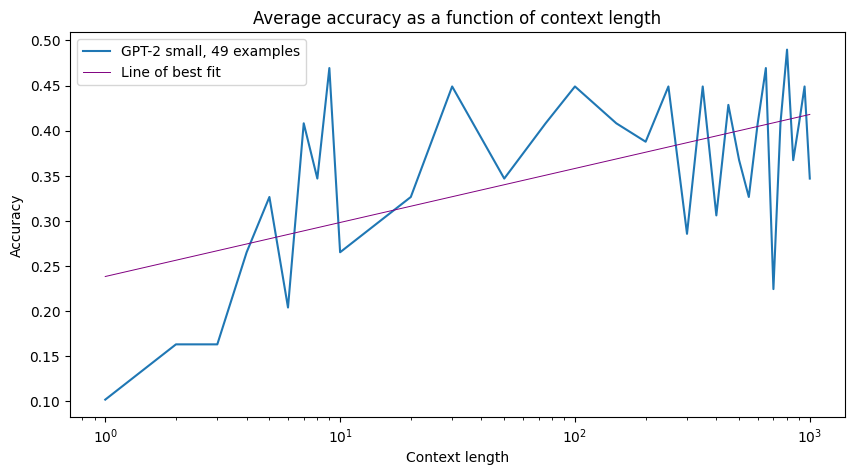

In [ ]:
plot(output_filename="gpt2small_datav1_clv2.json", label_line='GPT-2 small, 49 examples')

##### GPT-2 x-large, 33 context lengths, 49 examples

In [ ]:
input_ids, attention_mask = encode(text=text, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_datav1_clv2.json")

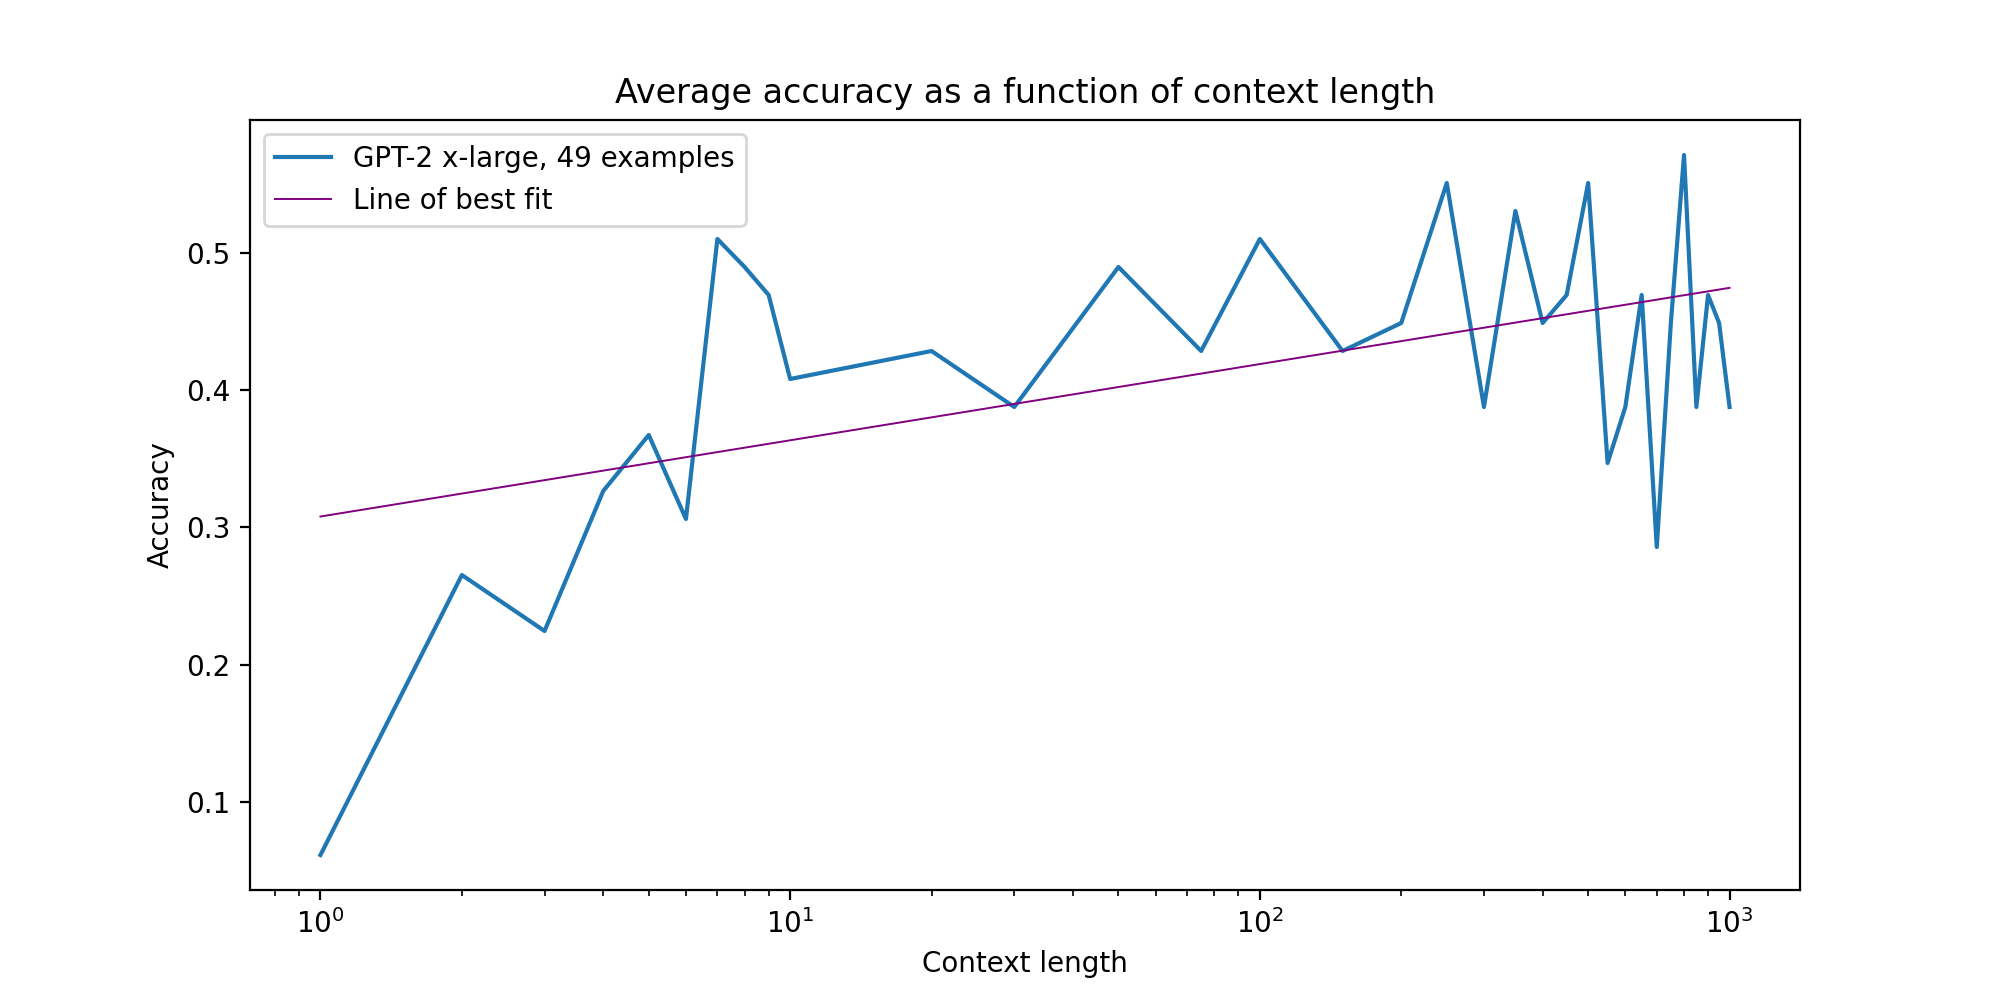

In [ ]:
plot(output_filename="gpt2large_datav1_clv2.json", label_line='GPT-2 x-large, 49 examples')

##### GPT-2 small, 33 context lengths, 75 examples

In [ ]:
input_ids, attention_mask = encode(text=text2, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_datav2_clv2.json")

In [ ]:
input_ids.size()

torch.Size([75, 1001])

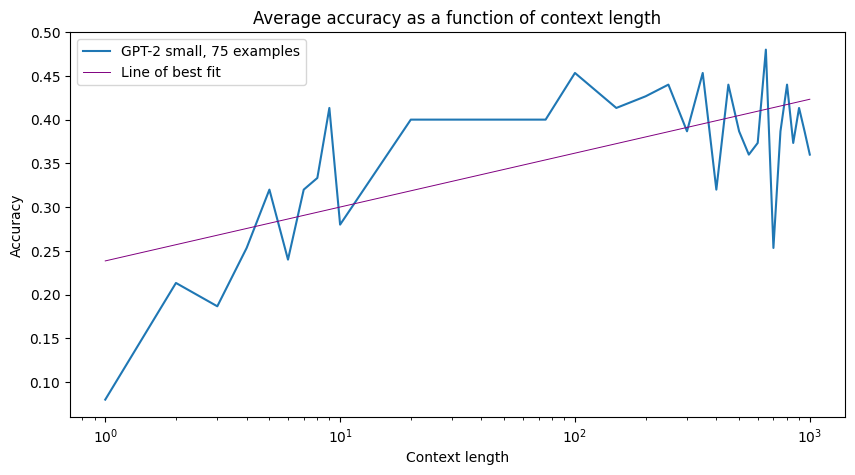

In [ ]:
plot(output_filename="gpt2small_datav2_clv2.json", label_line='GPT-2 small, 75 examples')

##### GPT-2 x-large, 33 context lengths, 75 examples

In [ ]:
input_ids, attention_mask = encode(text=text2, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_datav2_clv2.json")

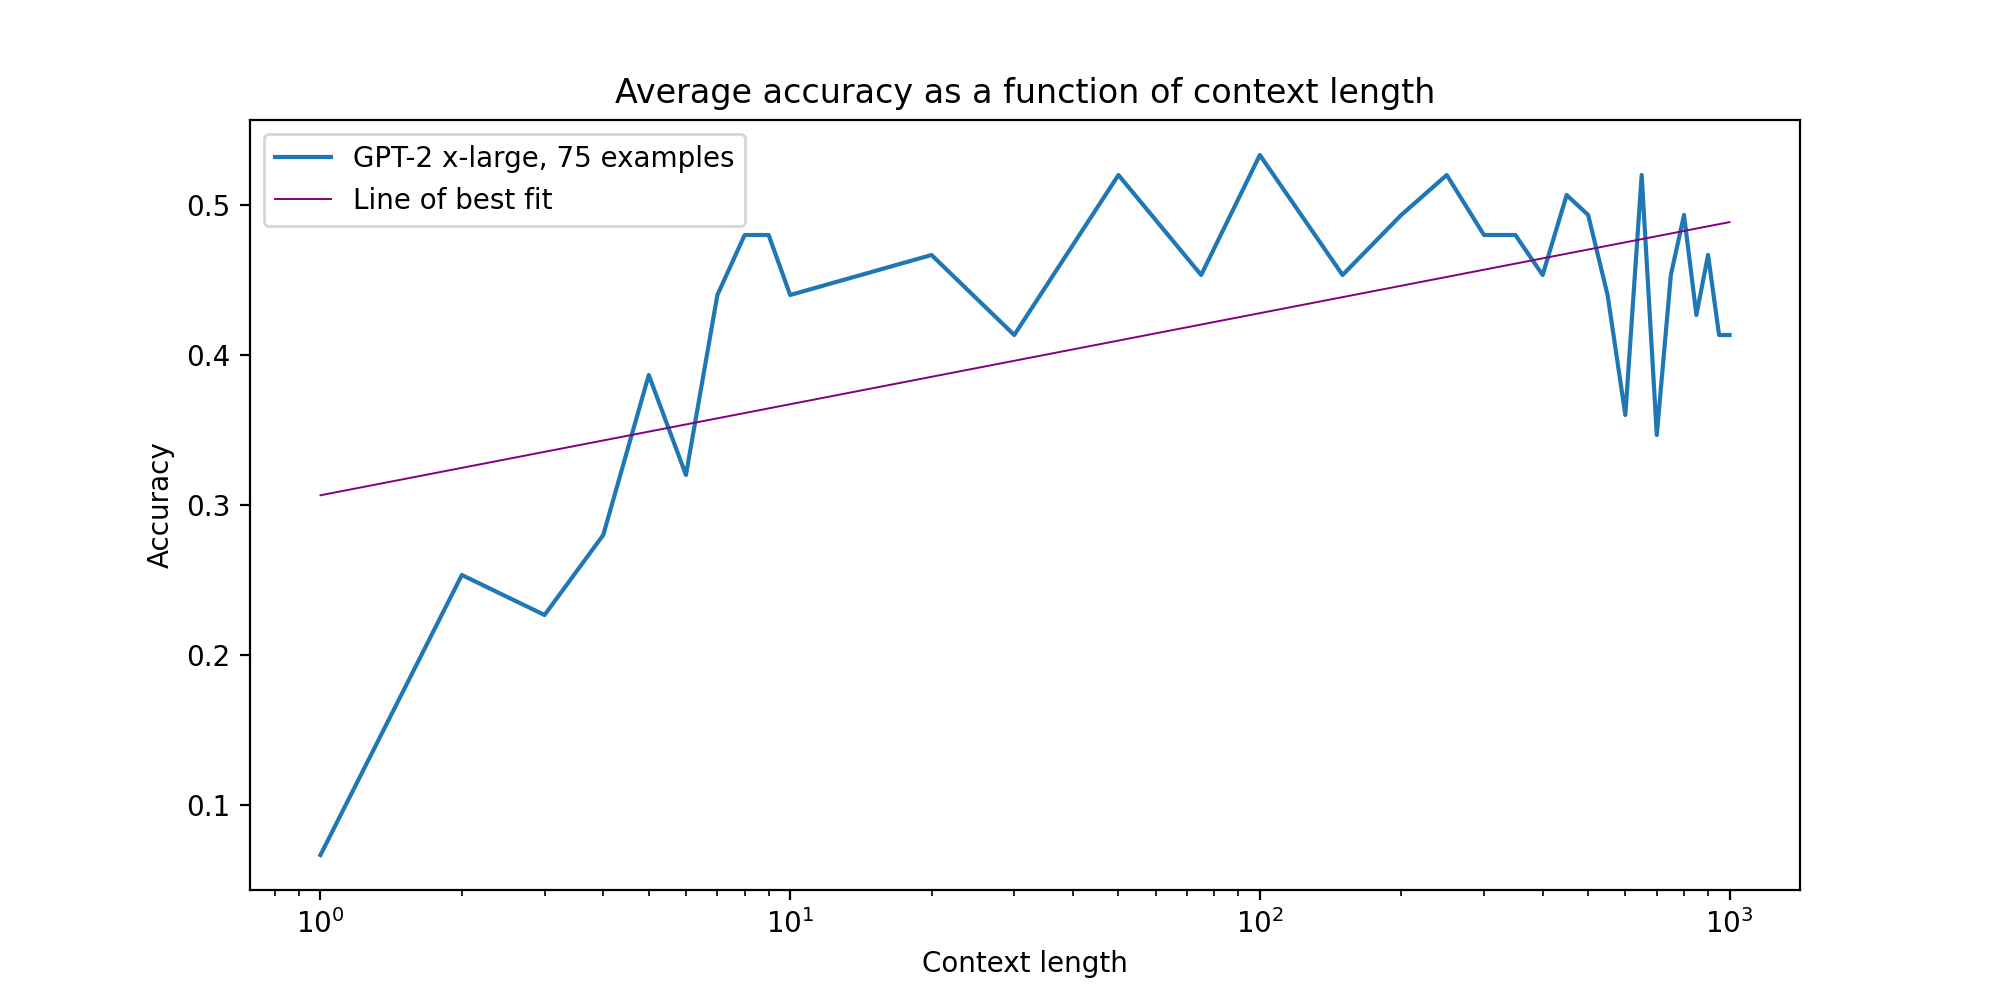

In [ ]:
plot(output_filename="gpt2large_datav2_clv2.json", label_line='GPT-2 x-large, 75 examples')

##### GPT-2 small, 33 context lengths, 100 examples (preprocessed)

In [ ]:
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_datav3_clv2.json", top_x=1)

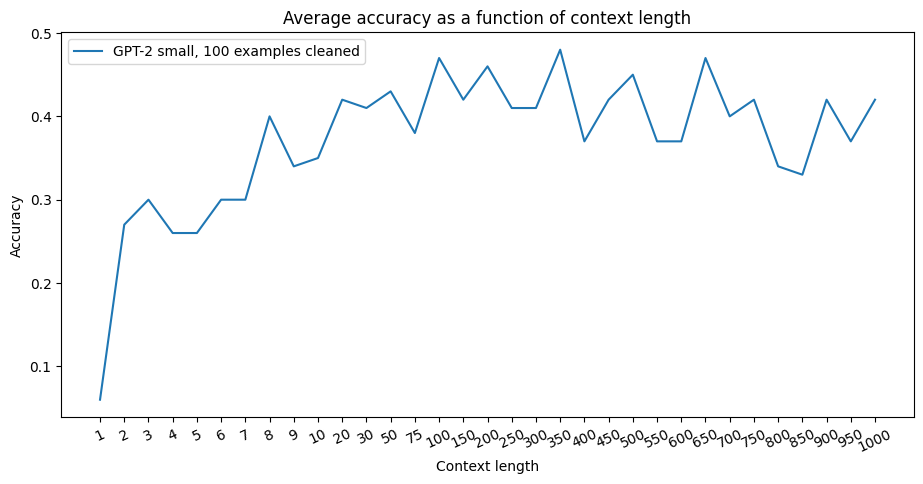

In [ ]:
plot(output_filename="gpt2small_datav3_clv2.json", label_line='GPT-2 small, 100 examples cleaned')

##### GPT-2 x-large, 33 context lengths, 100 examples (preprocessed)

In [ ]:
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_datav3_clv2.json", top_x=1)

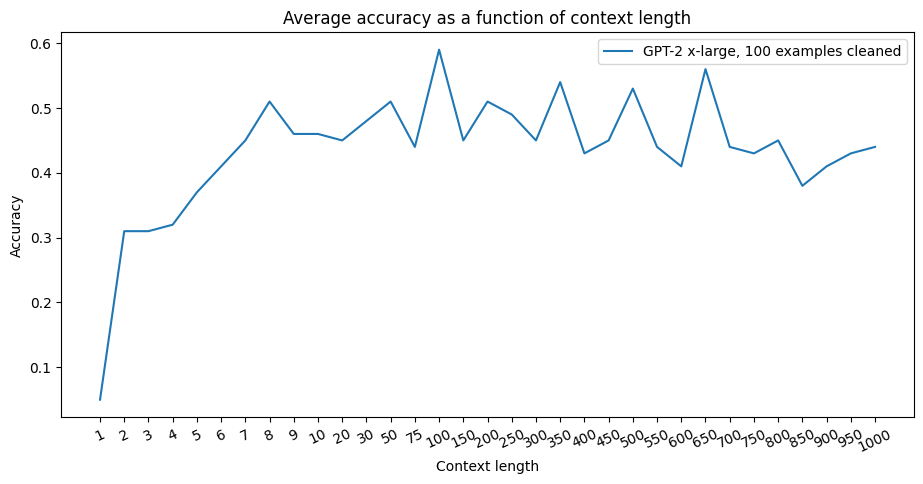

In [ ]:
plot(output_filename="gpt2large_datav3_clv2.json", label_line='GPT-2 x-large, 100 examples cleaned')

##### Top-2 GPT-2 small, 33 context lengths, 100 examples (preprocessed)

In [ ]:
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=8, file_name = "gpt2small_datav3_clv2_top2.json", top_x=2)

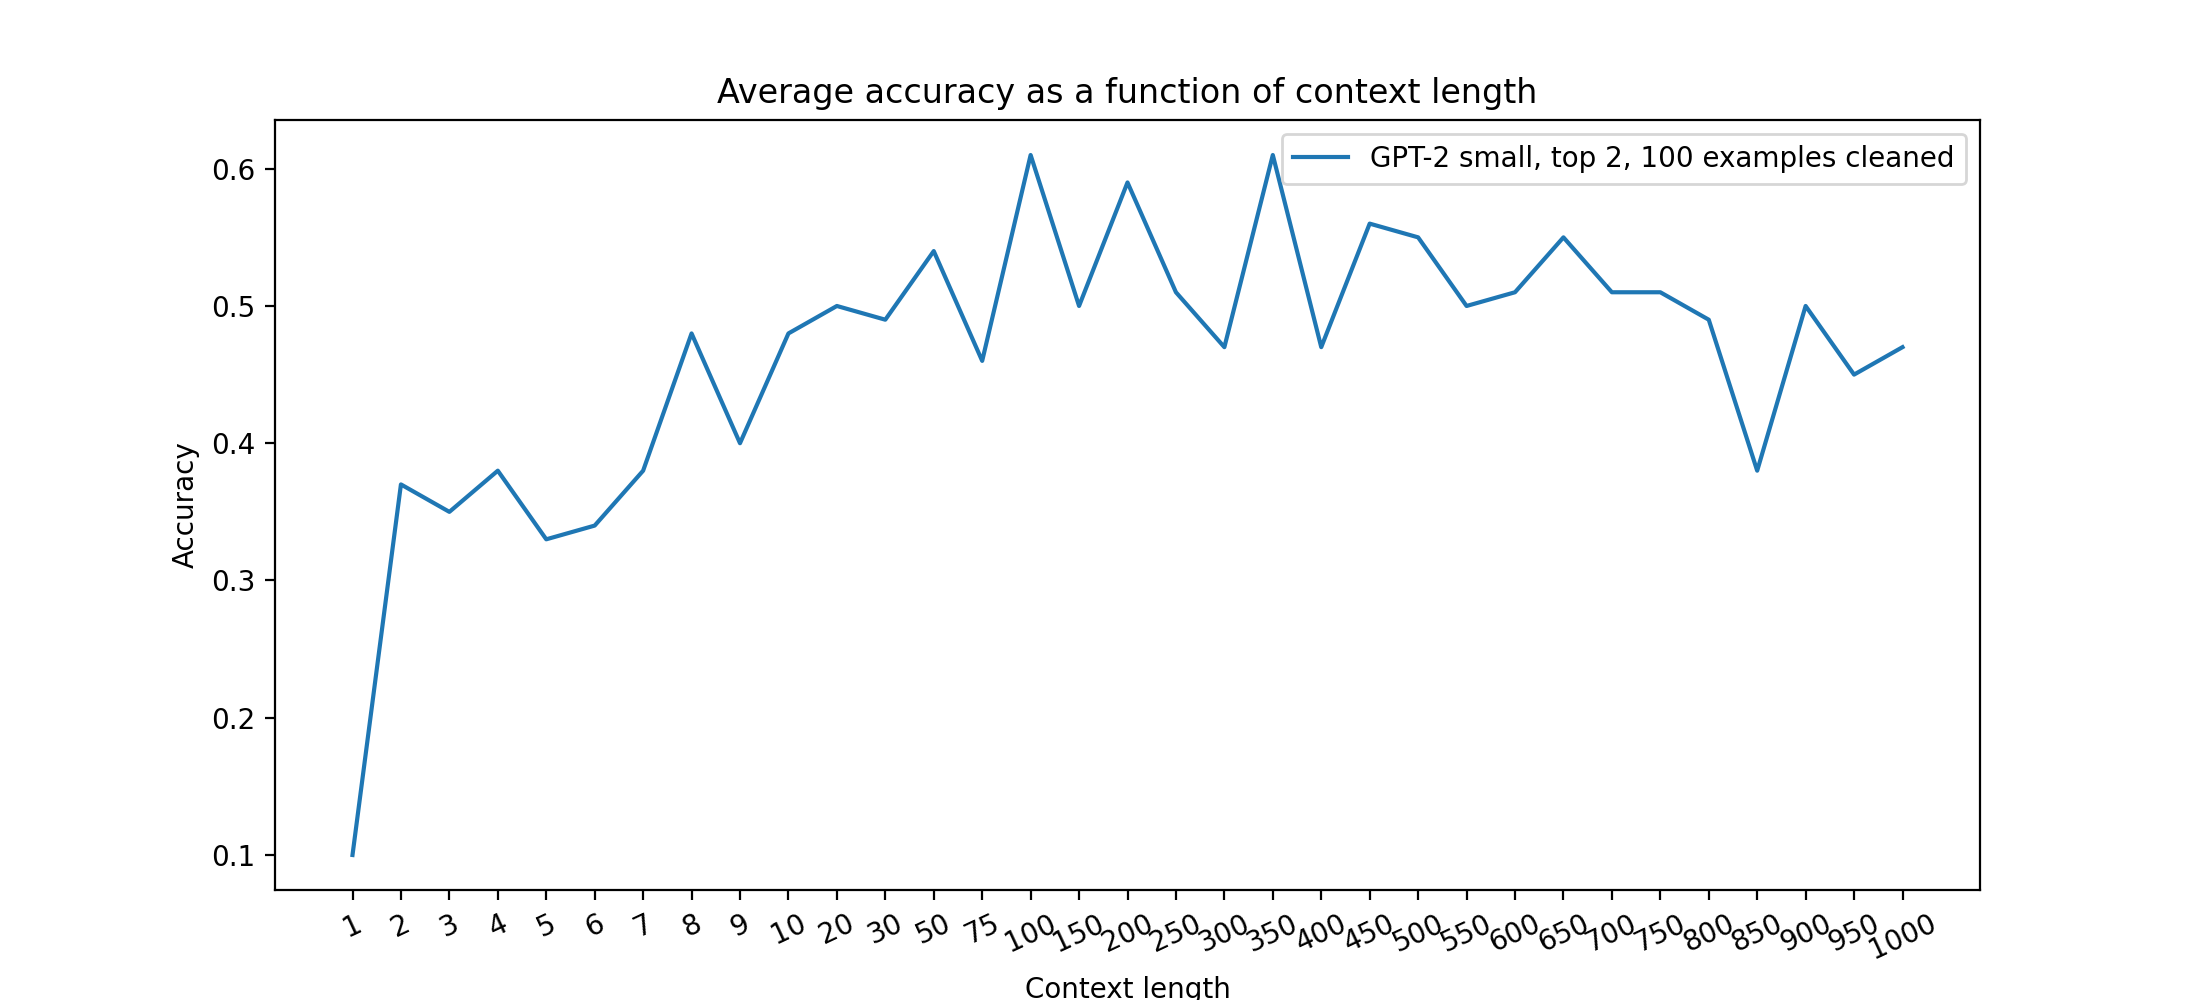

In [ ]:
plot(output_filename="gpt2small_datav3_clv2_top2.json", label_line='GPT-2 small, top 2, 100 examples cleaned')

##### Top-2 GPT-2 x-large, 33 context lengths, 100 examples (preprocessed)

In [ ]:
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
probs = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_datav3_clv2_top2.json", top_x=2)

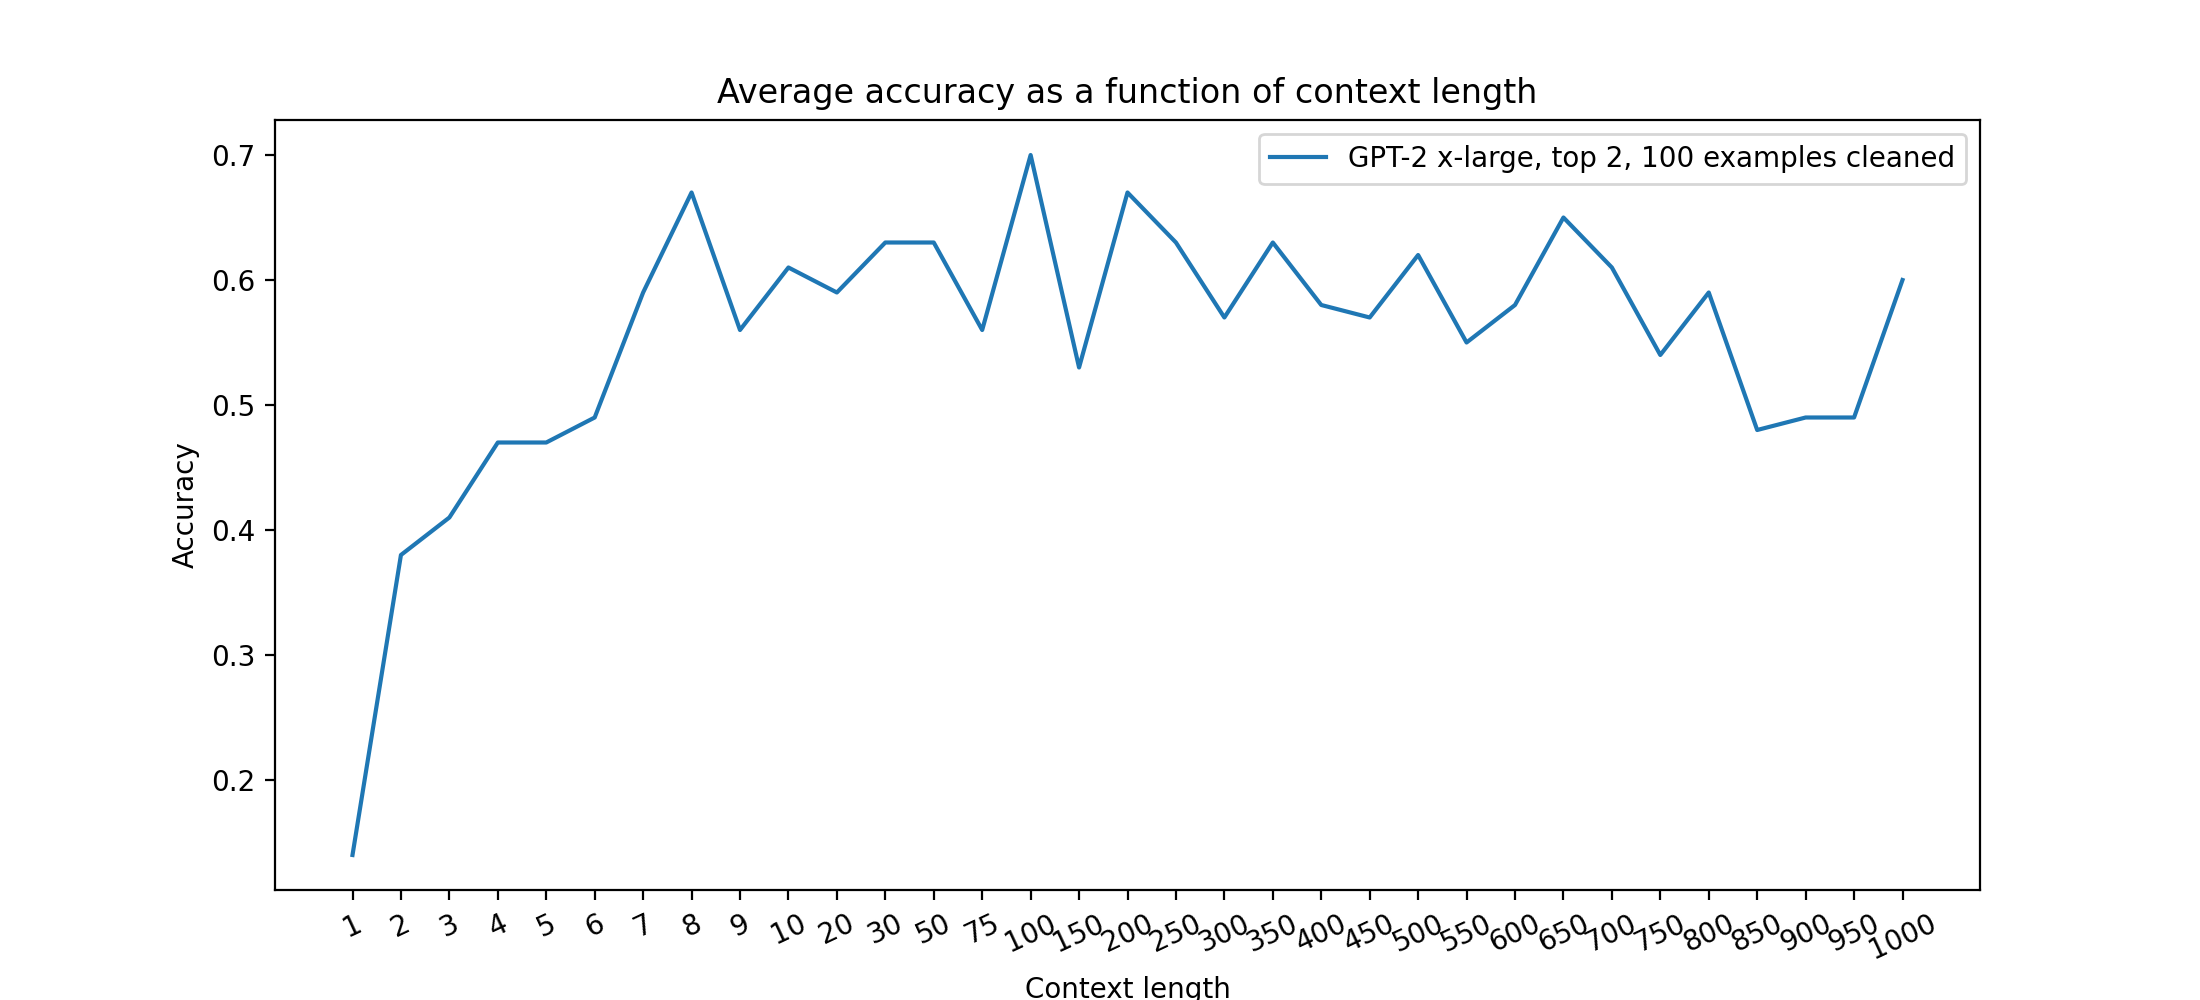

In [ ]:
plot(output_filename="gpt2large_datav3_clv2_top2.json", label_line='GPT-2 x-large, top 2, 100 examples cleaned')

##### Top-3 GPT-2 x-large, 33 context lengths, 100 examples (preprocessed)

In [ ]:
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_datav3_clv2_top3.json", top_x=3)

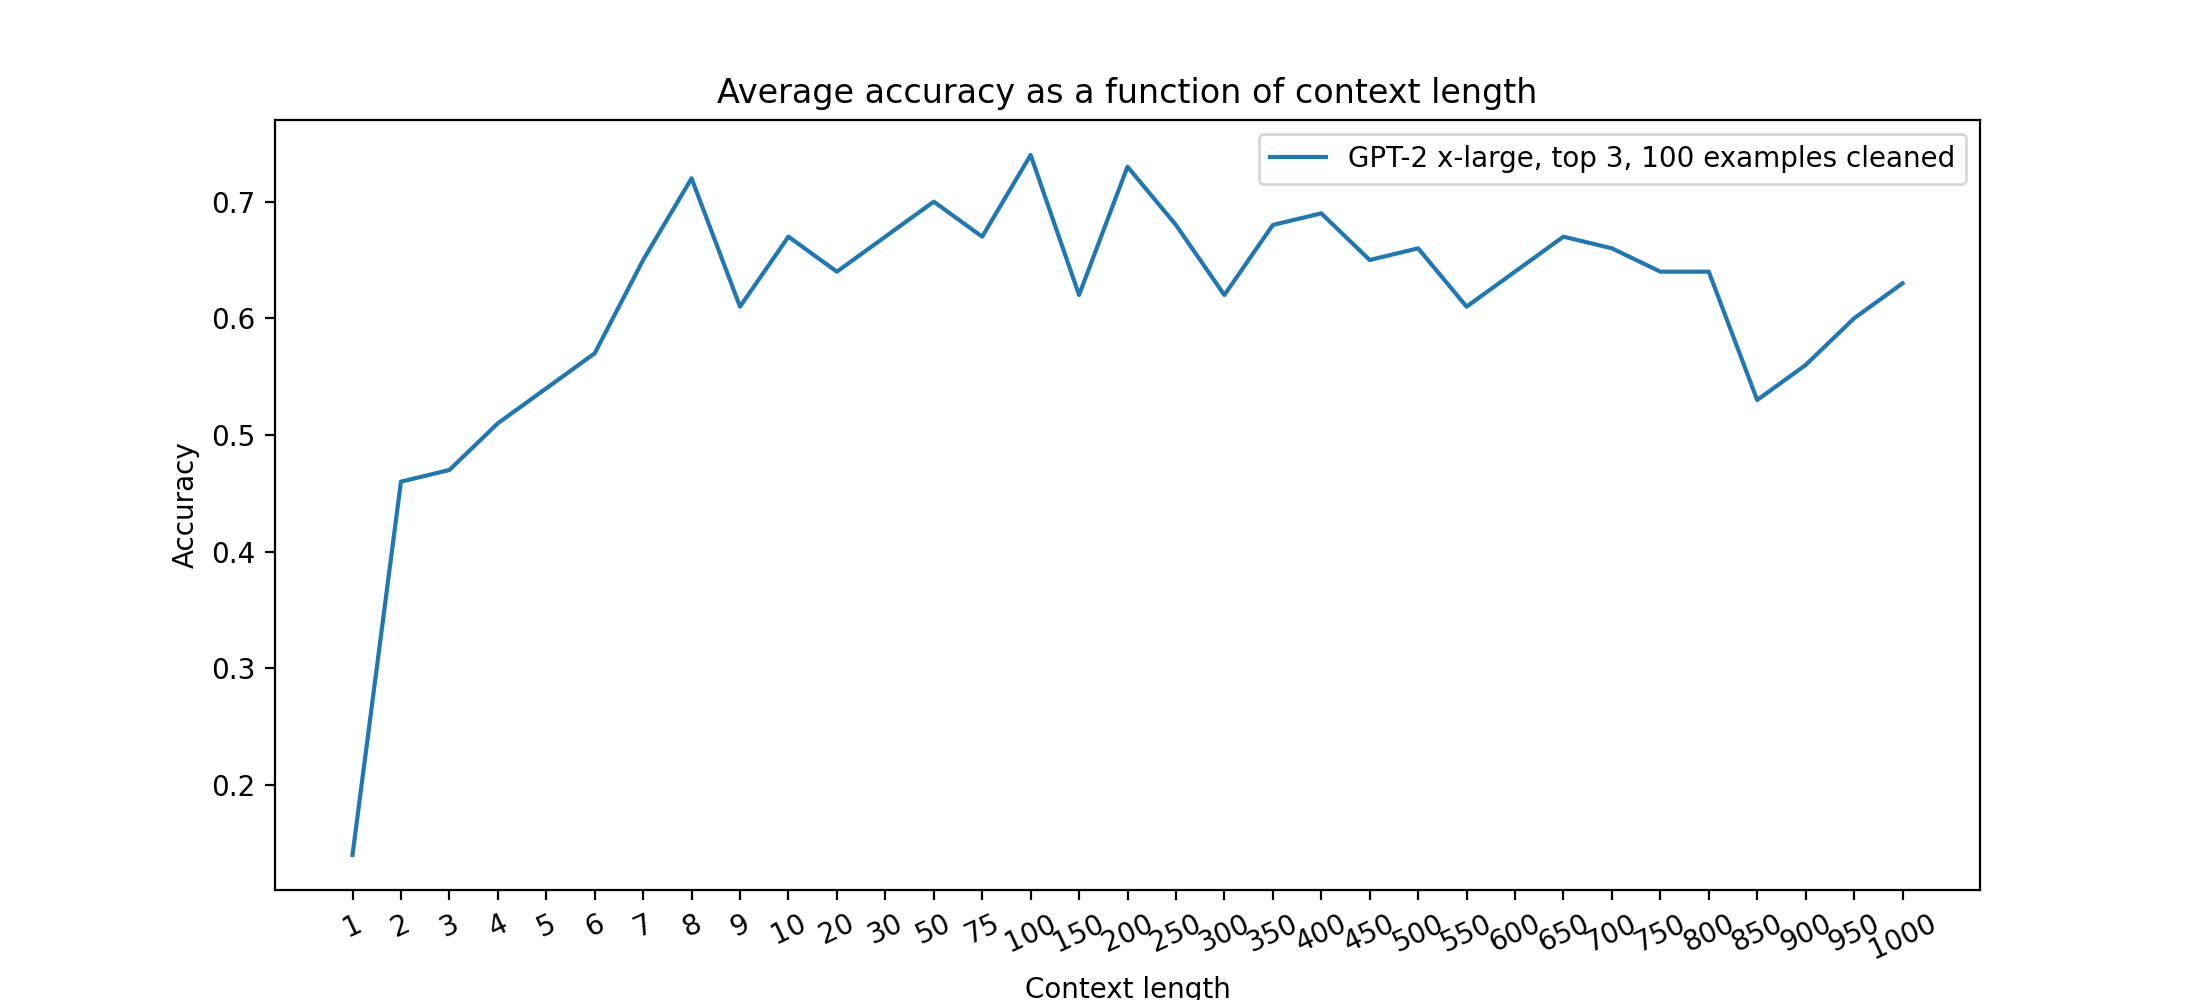

In [ ]:
plot(output_filename="gpt2large_datav3_clv2_top3.json", label_line='GPT-2 x-large, top 3, 100 examples cleaned')

##### Top-4 GPT-2 x-large, 33 context lengths, 100 examples (preprocessed)

In [ ]:
input_ids, attention_mask = encode(text=text_clean, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_datav3_clv2_top4.json", top_x=4)

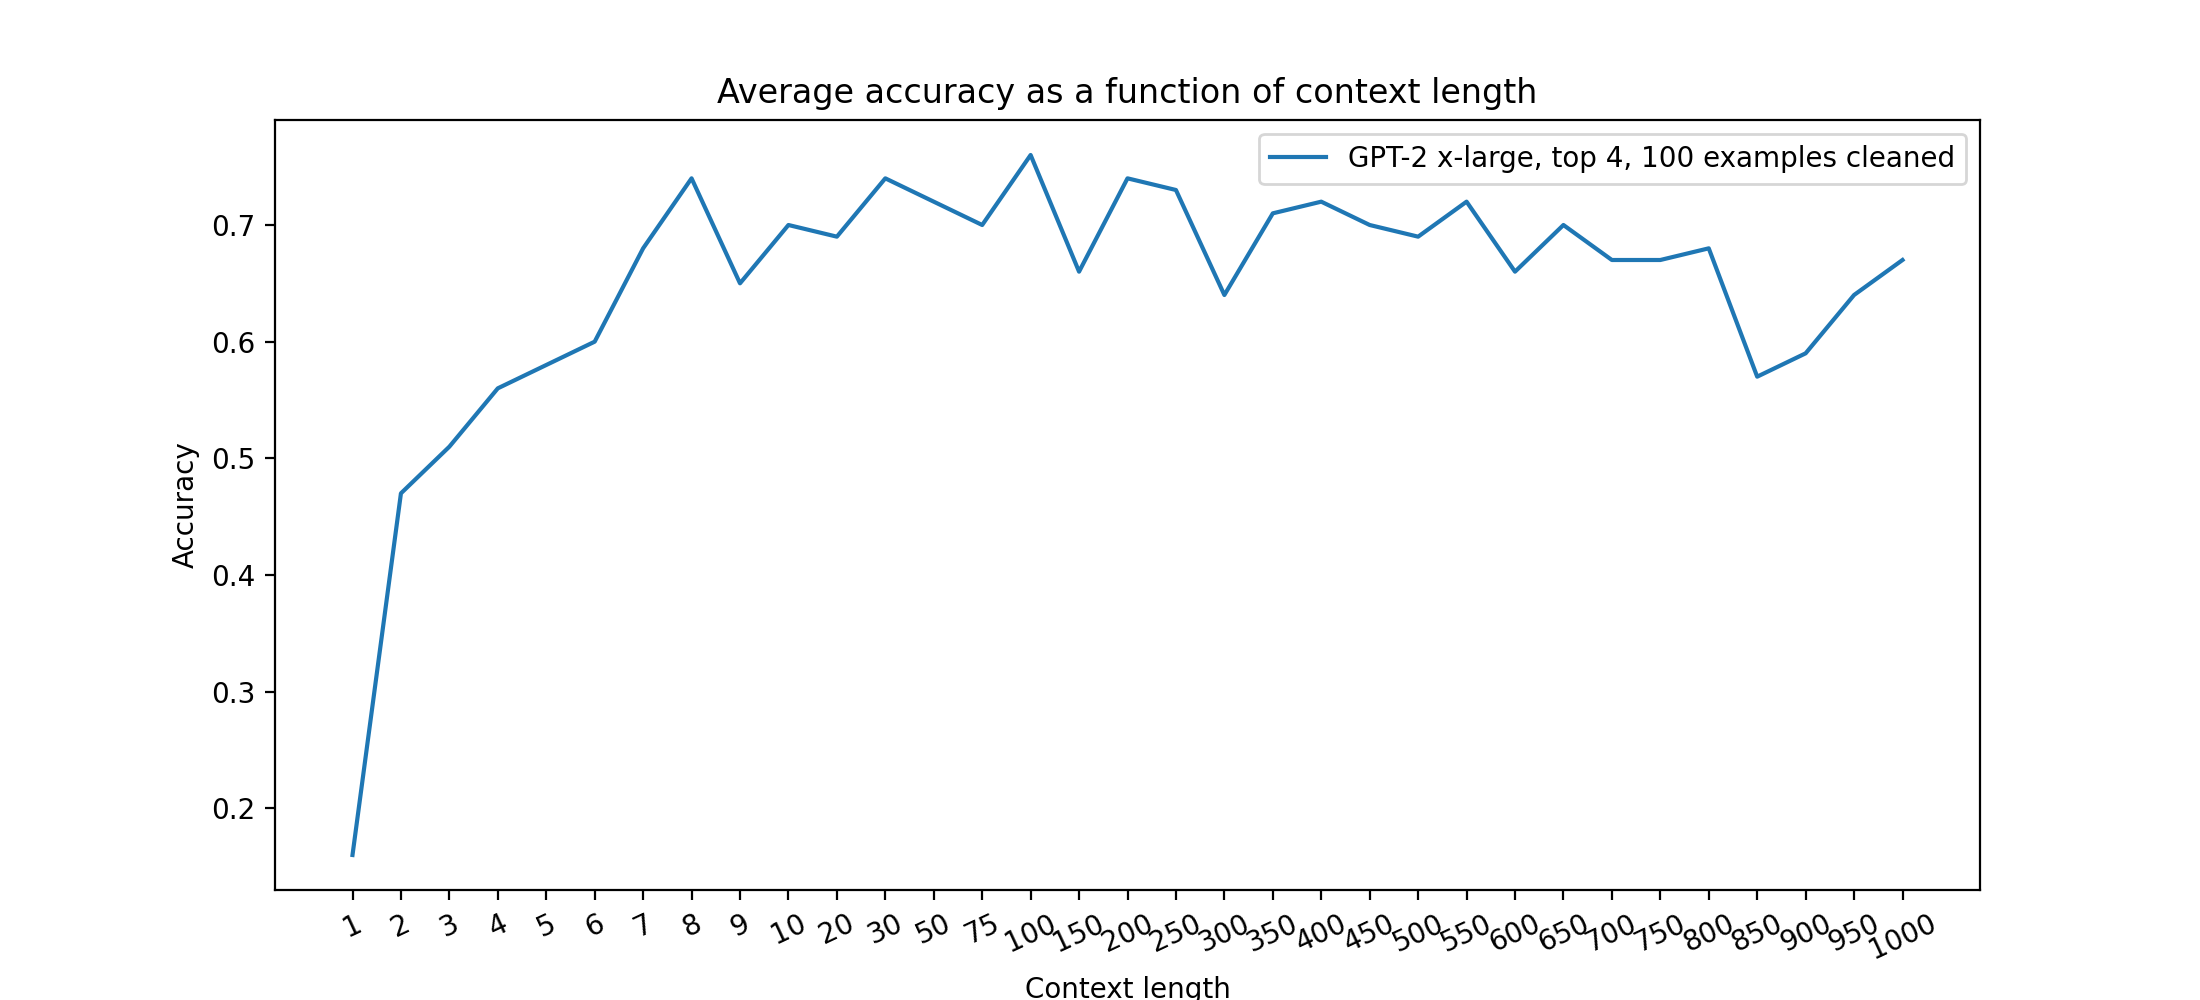

In [ ]:
plot(output_filename="gpt2large_datav3_clv2_top4.json", label_line='GPT-2 x-large, top 4, 100 examples cleaned')

In [ ]:
from plotnine import (
    ggplot,
    aes,
    geom_point,
    geom_smooth,
    labs,
    theme_bw,
    scale_x_log10,
    labels
)
from plotnine.data import mpg
from plotnine import scales

/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


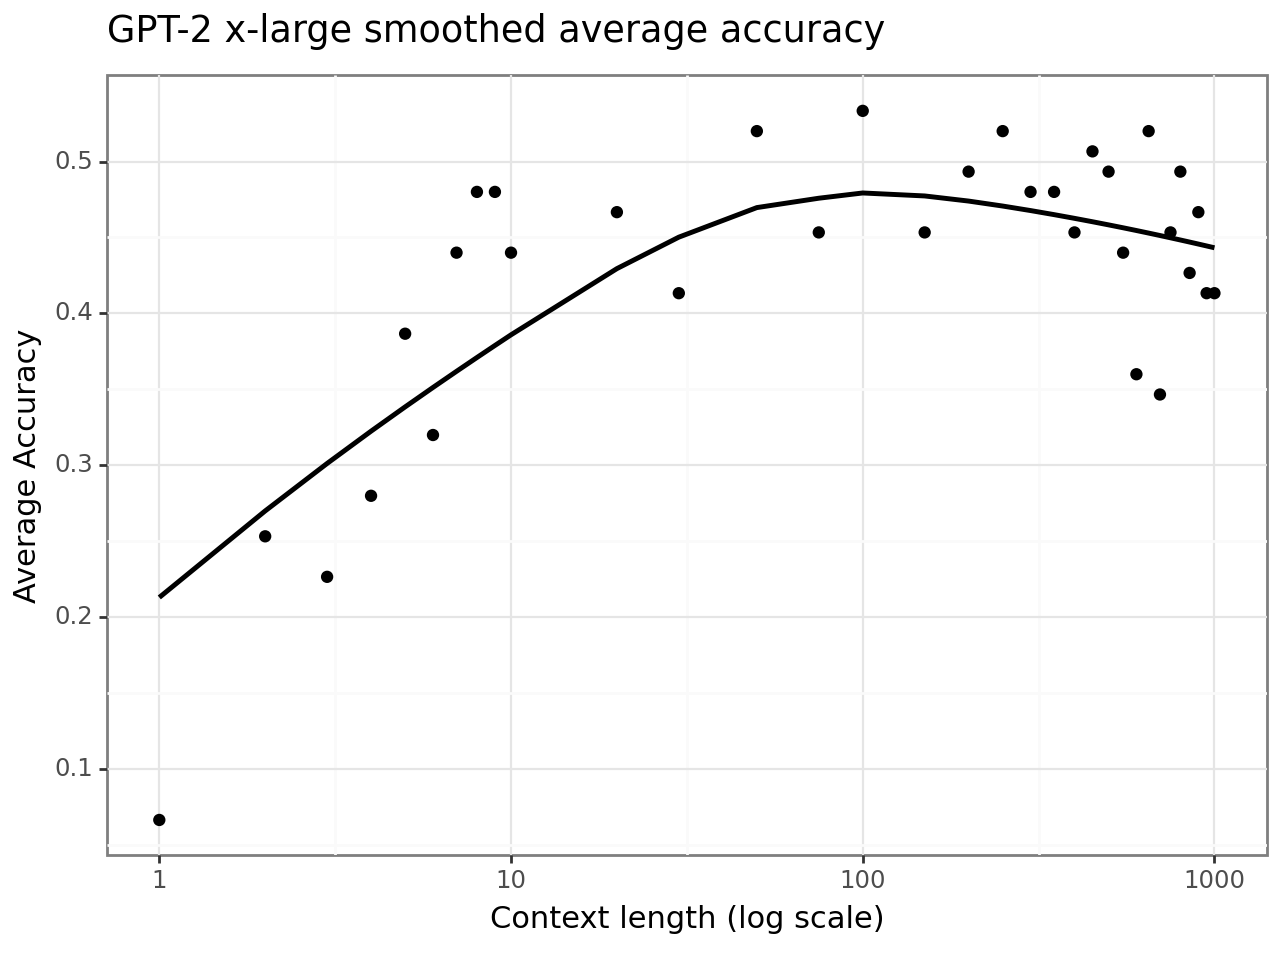

<Figure Size: (640 x 480)>

In [ ]:
with open("gpt2large_datav2_clv2.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_n = np.log10(np.array(list(acc_large), dtype='float64'))
y_n = np.array(list(acc_large.values()), dtype='float64')
d = pd.DataFrame({"x": x_n, "y": y_n})
(
    ggplot(d, aes(x='x', y='y'))
    + geom_point()
    + geom_smooth()
    + labs(x='Context length (log scale)', y='Average Accuracy')
    + theme_bw()
    + scales.scale_x_continuous(labels=[1, 10, 100, 1000])
    + labels.ggtitle(title="GPT-2 x-large smoothed average accuracy")
)

/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


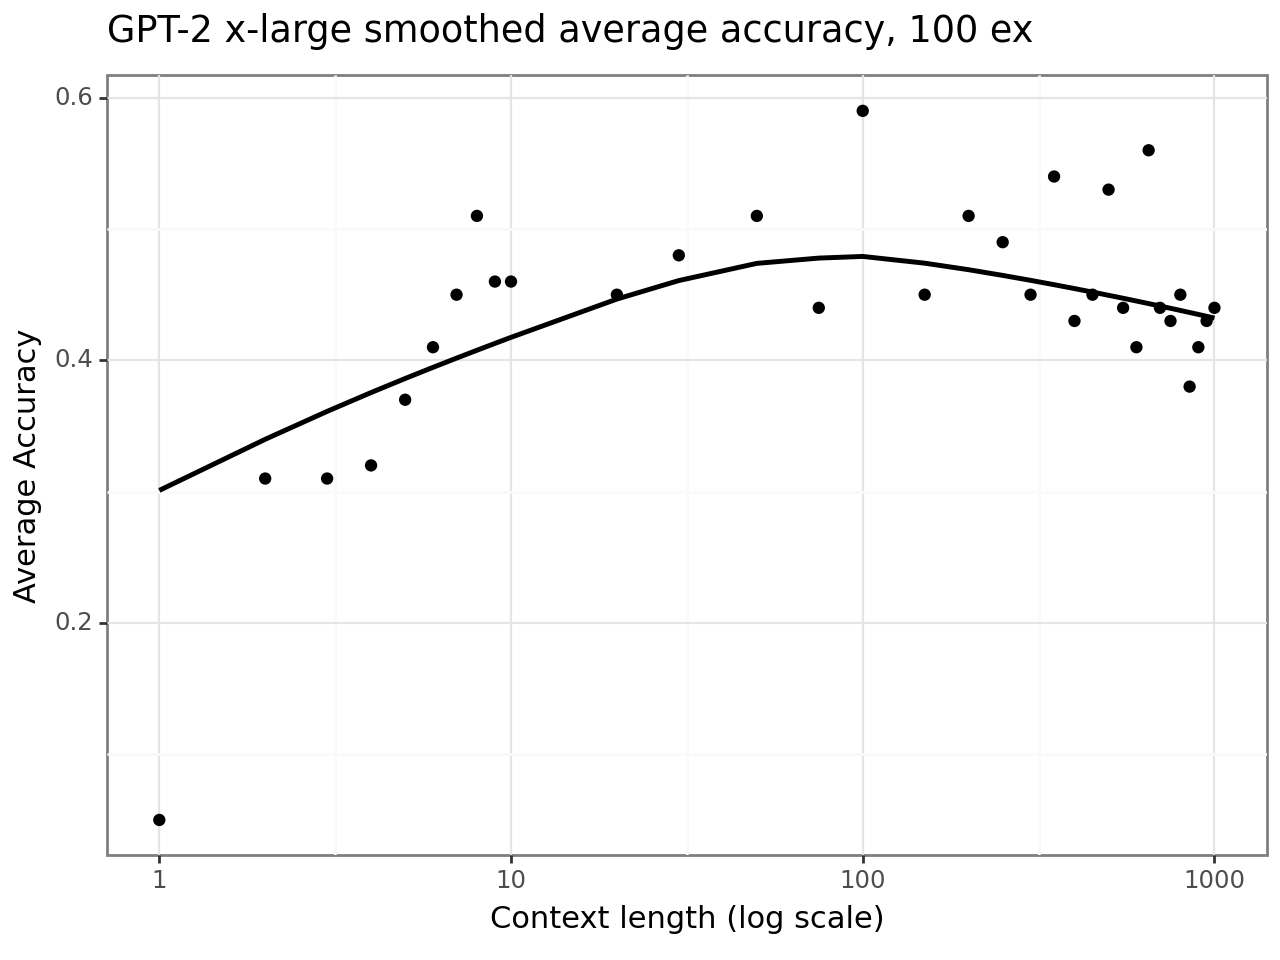

<Figure Size: (640 x 480)>

In [ ]:
with open("gpt2large_datav3_clv2.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_n = np.log10(np.array(list(acc_large), dtype='float64'))
y_n = np.array(list(acc_large.values()), dtype='float64')
d = pd.DataFrame({"x": x_n, "y": y_n})
(
    ggplot(d, aes(x='x', y='y'))
    + geom_point()
    + geom_smooth()
    + labs(x='Context length (log scale)', y='Average Accuracy')
    + theme_bw()
    + scales.scale_x_continuous(labels=[1, 10, 100, 1000])
    + labels.ggtitle(title="GPT-2 x-large smoothed average accuracy, 100 ex")
)

### Comparisons

##### GPT-2 small vs x-large - 49 ex

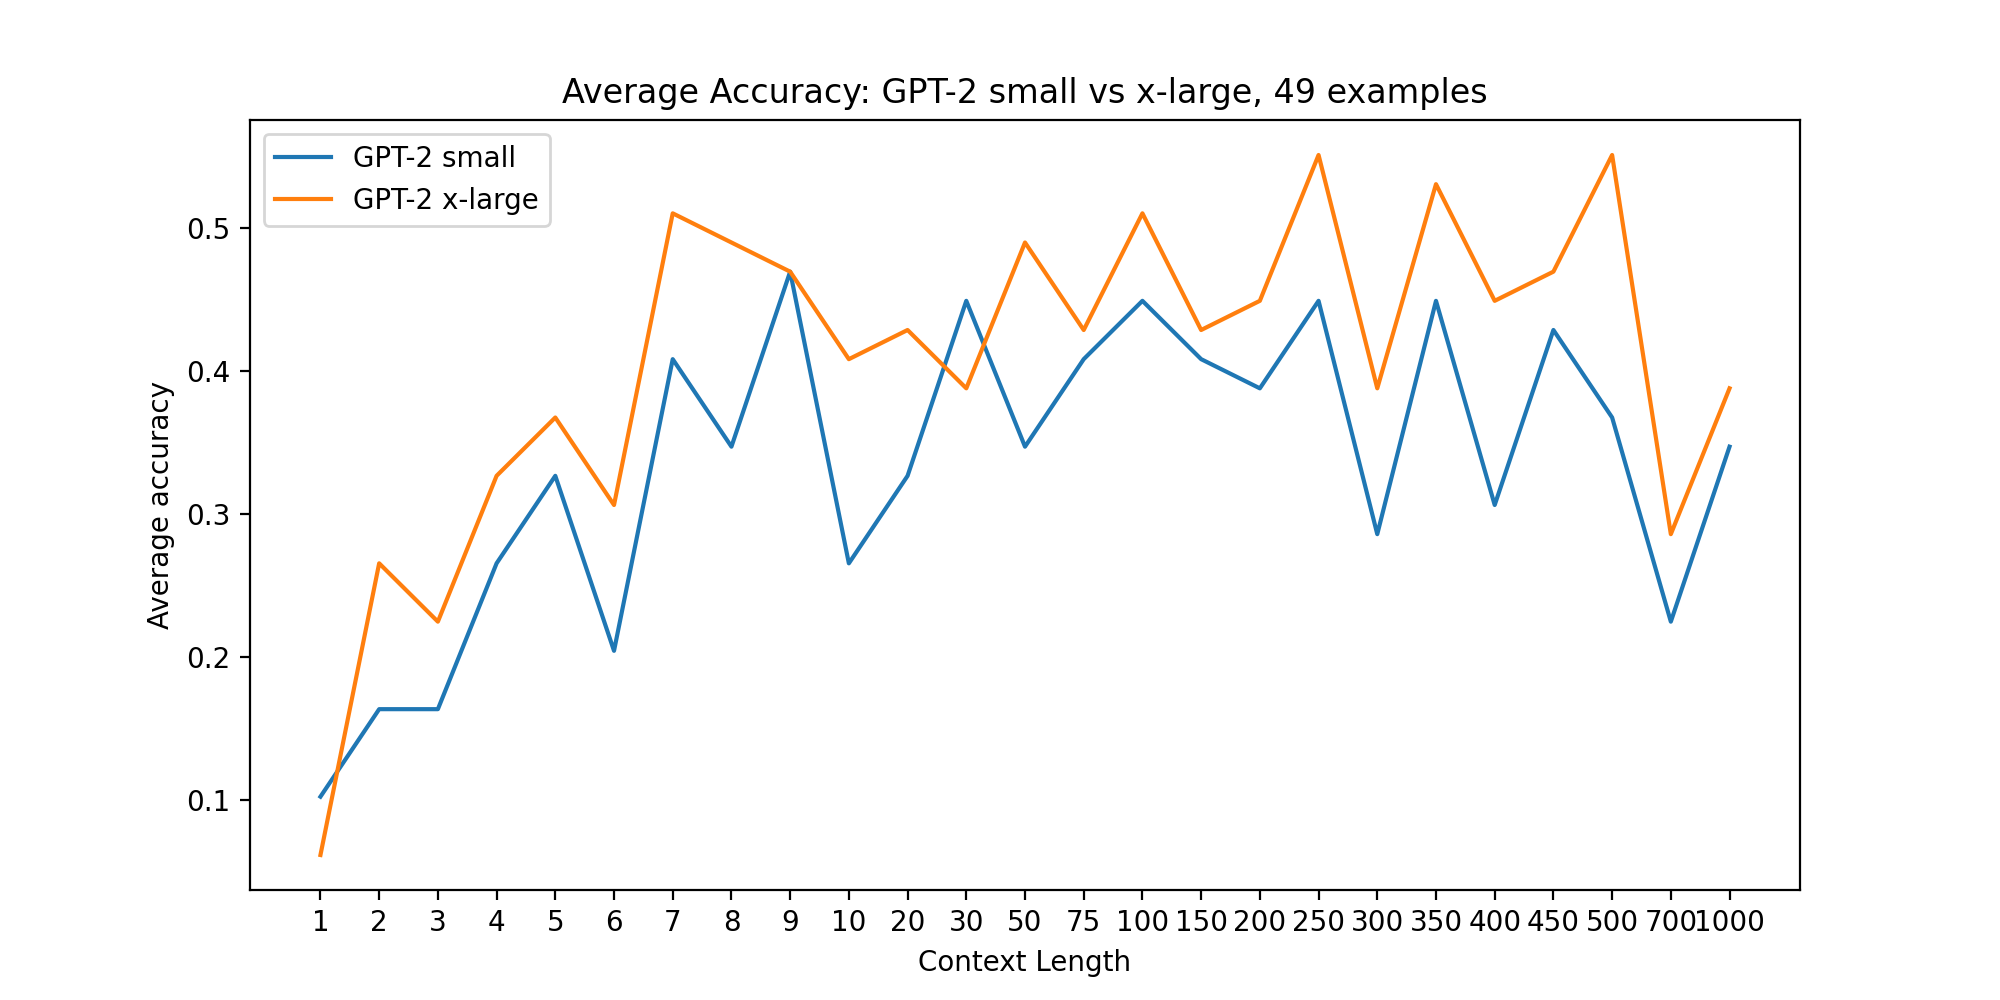

In [ ]:
with open("gpt2small_datav1_clv1.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav1_clv1.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_1 = list(acc_small)
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = list(acc_large)
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small")
plt.plot(x_2, y_2, label="GPT-2 x-large")
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large, 49 examples")
plt.show()

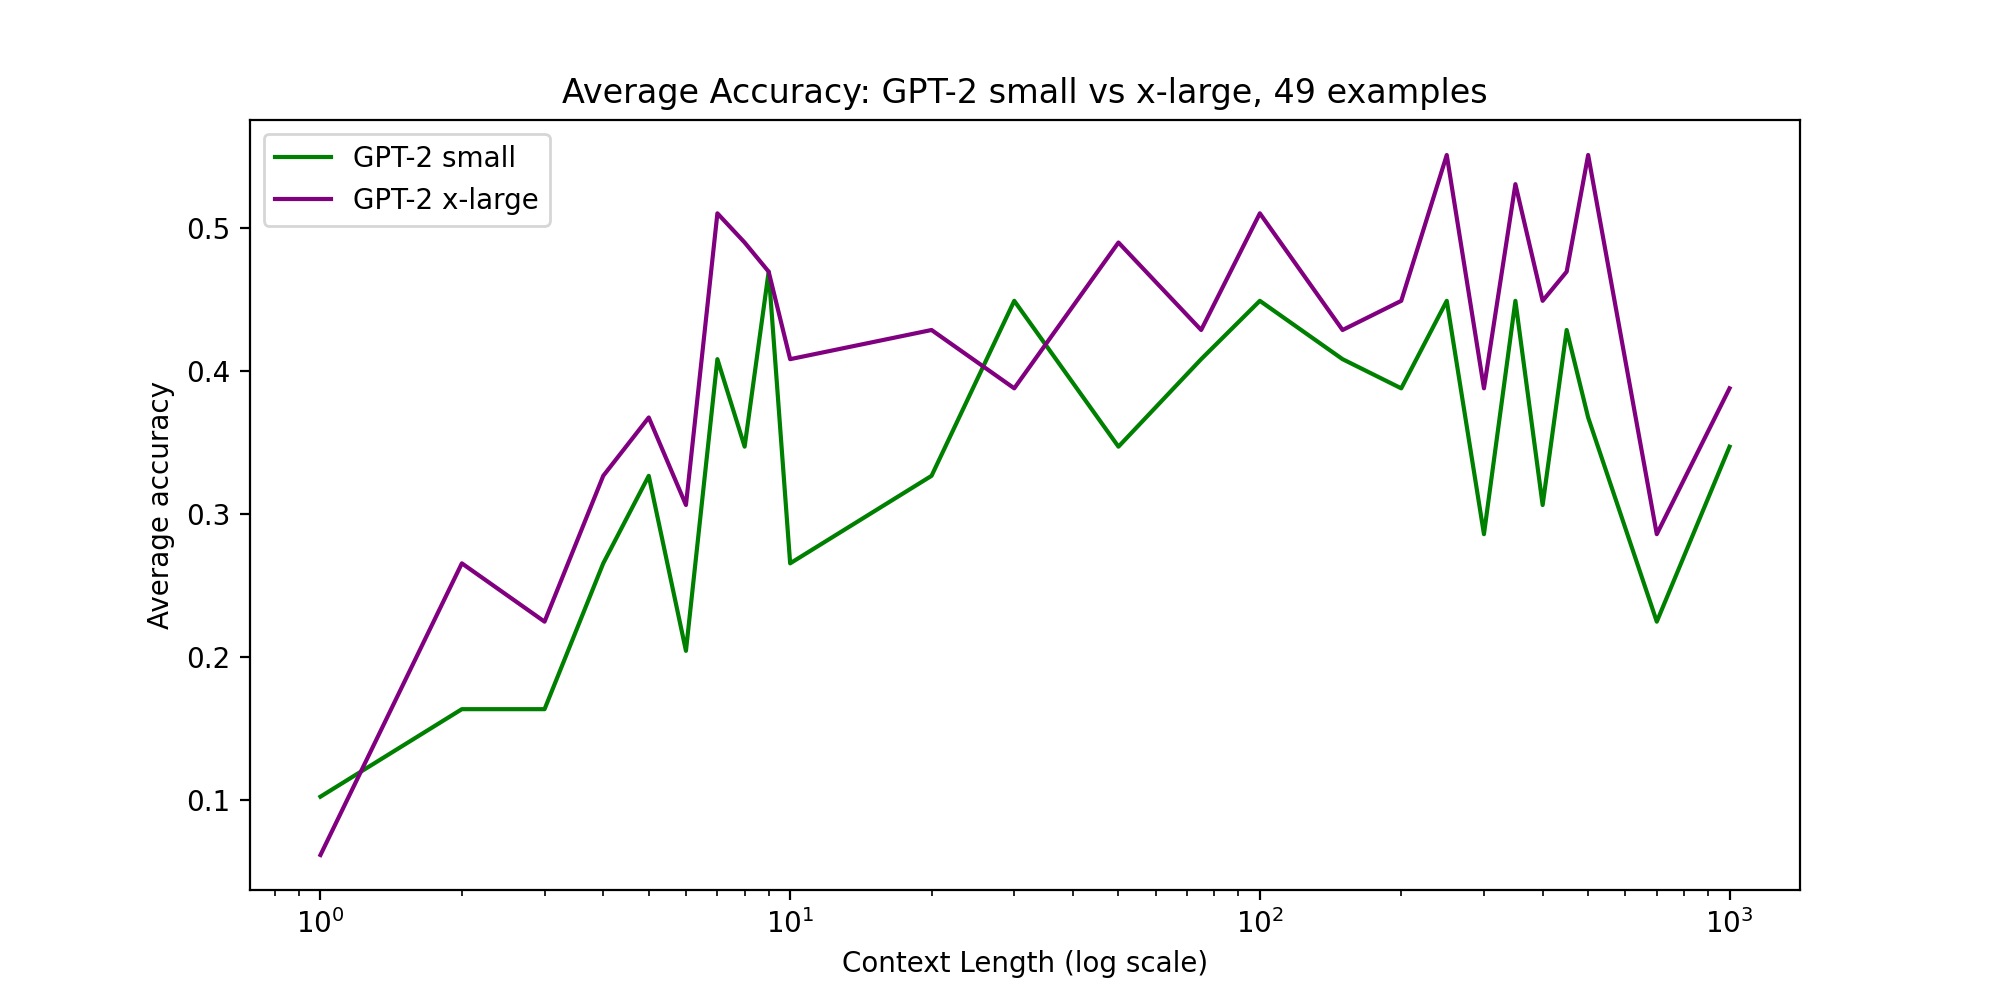

In [ ]:
with open("gpt2small_datav1_clv1.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav1_clv1.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_1 = np.array(list(acc_small), dtype='int')
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = np.array(list(acc_large), dtype='float64')
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small", color="green")
plt.plot(x_2, y_2, label="GPT-2 x-large", color="purple")
plt.xscale('log')
#plt.xticks(x_1, x_1)
plt.legend()
plt.xlabel("Context Length (log scale)")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large, 49 examples")
plt.show()

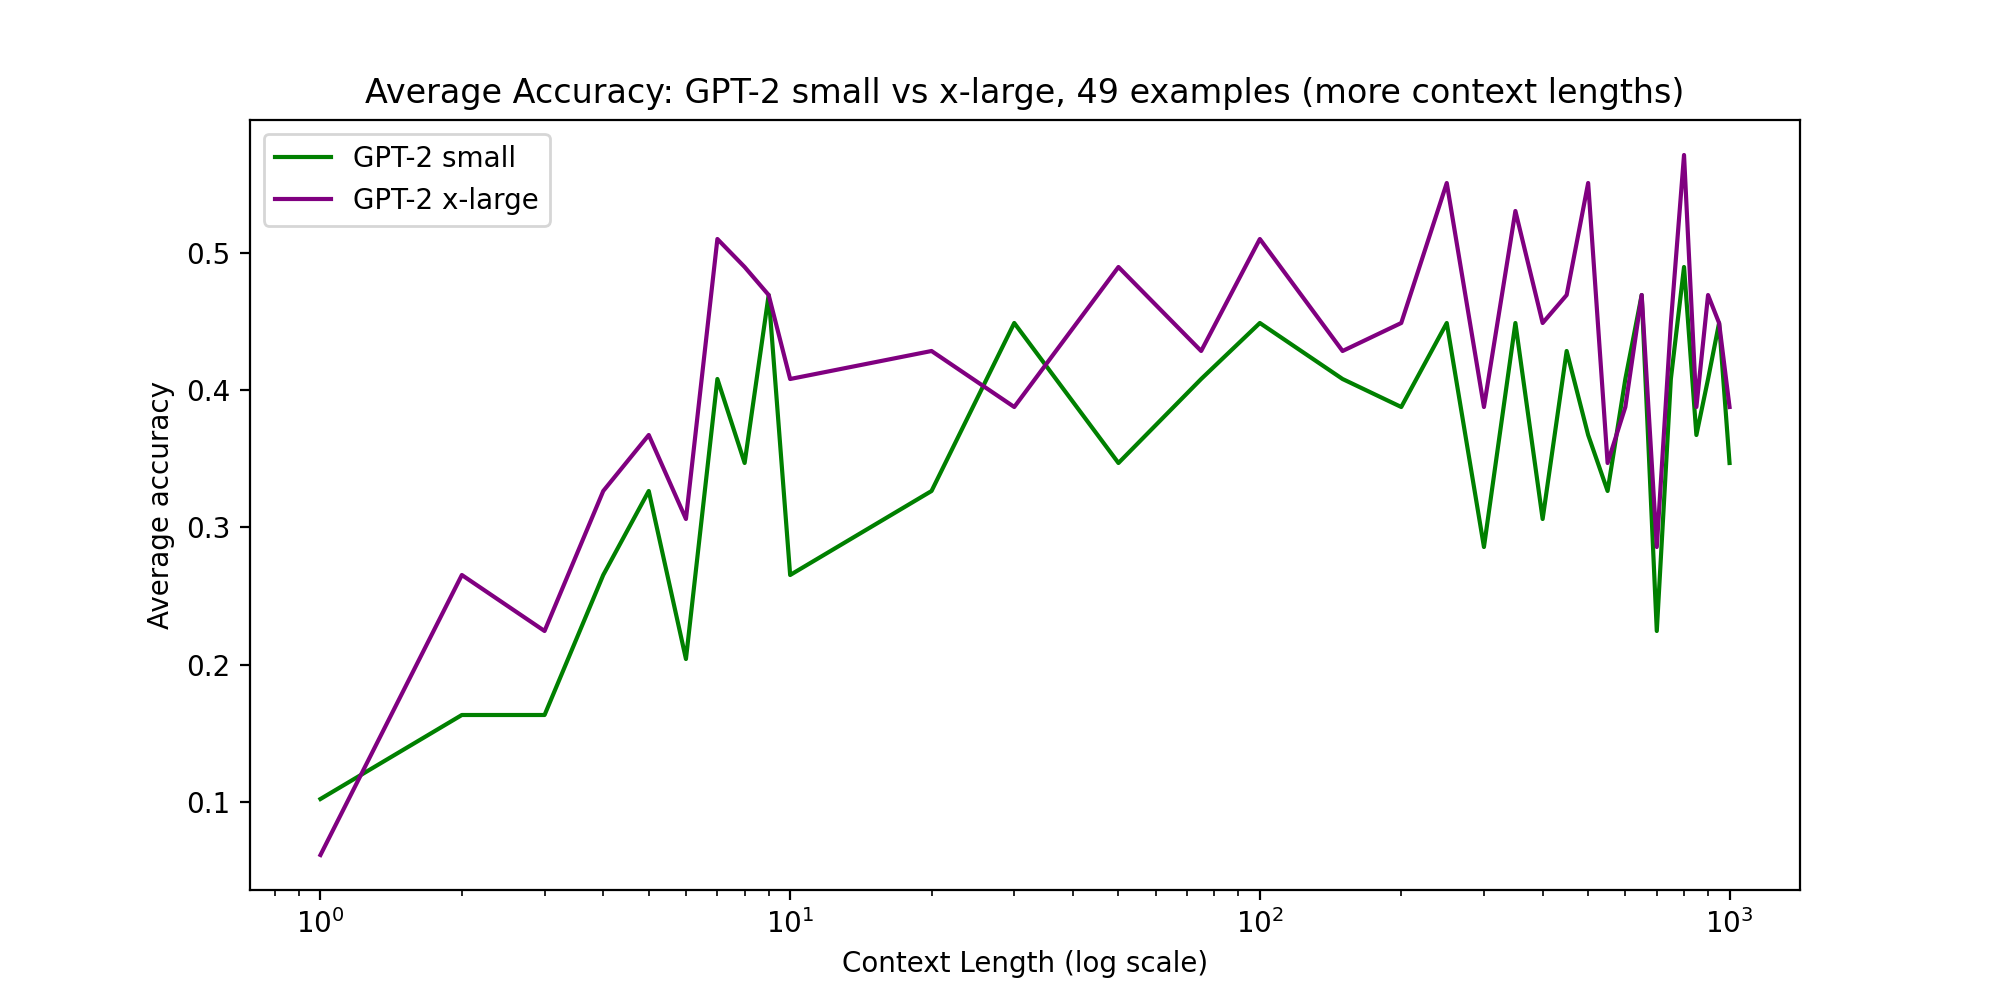

In [ ]:
with open("gpt2small_datav1_clv2.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav1_clv2.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_1 = np.array(list(acc_small), dtype='float64')
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = np.array(list(acc_large), dtype='float64')
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small", color="green")
plt.plot(x_2, y_2, label="GPT-2 x-large", color="purple")
plt.xscale('log')
plt.legend()
plt.xlabel("Context Length (log scale)")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large, 49 examples (more context lengths)")
plt.show()

##### GPT-2 small vs x-large - 75 ex

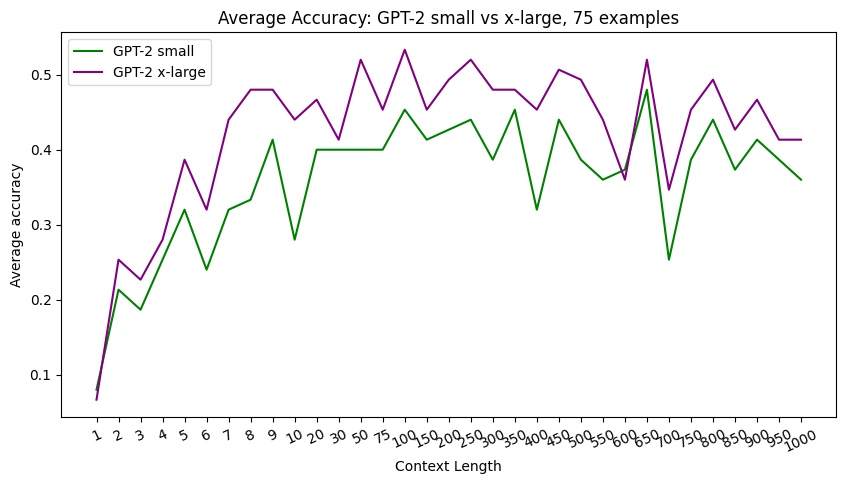

In [13]:
with open("gpt2small_datav2_clv2.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav2_clv2.json") as f:
  content = f.read()
acc_large = json.loads(content)
#x_1 = np.array(list(acc_small), dtype='float64')
x_1 = list(acc_small)
y_1 = np.array(list(acc_small.values()), dtype='float64')
#x_2 = np.array(list(acc_large), dtype='float64')
x_2 = list(acc_large)
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small", color='green')
plt.plot(x_2, y_2, label="GPT-2 x-large", color='purple')
#plt.xscale('log')
plt.xticks(rotation = 25)
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large, 75 examples")
plt.show()

##### GPT-2 small vs x-large - 100 ex (preprocessed)

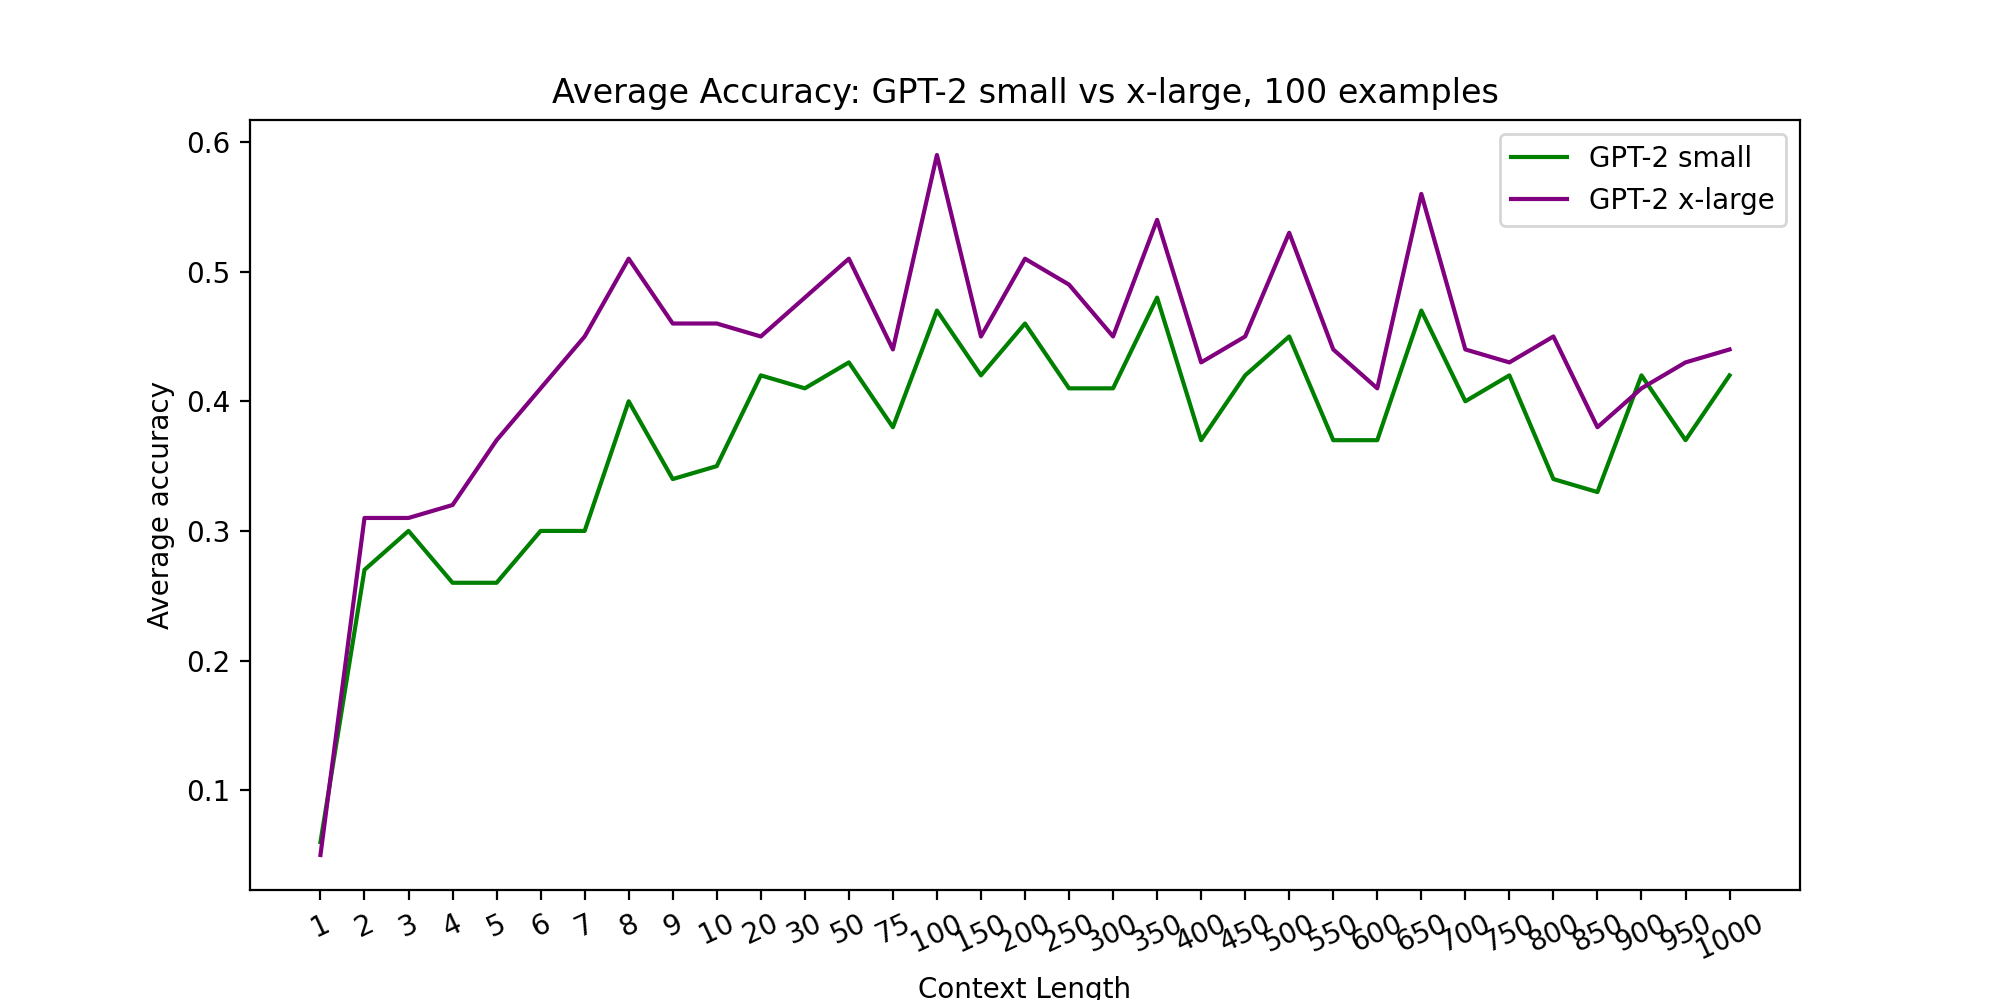

In [ ]:
with open("gpt2small_datav3_clv2.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav3_clv2.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_1 = list(acc_small)
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = list(acc_large)
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small", color='green')
plt.plot(x_2, y_2, label="GPT-2 x-large", color='purple')
plt.xticks(rotation = 25)
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large, 100 examples")
plt.show()

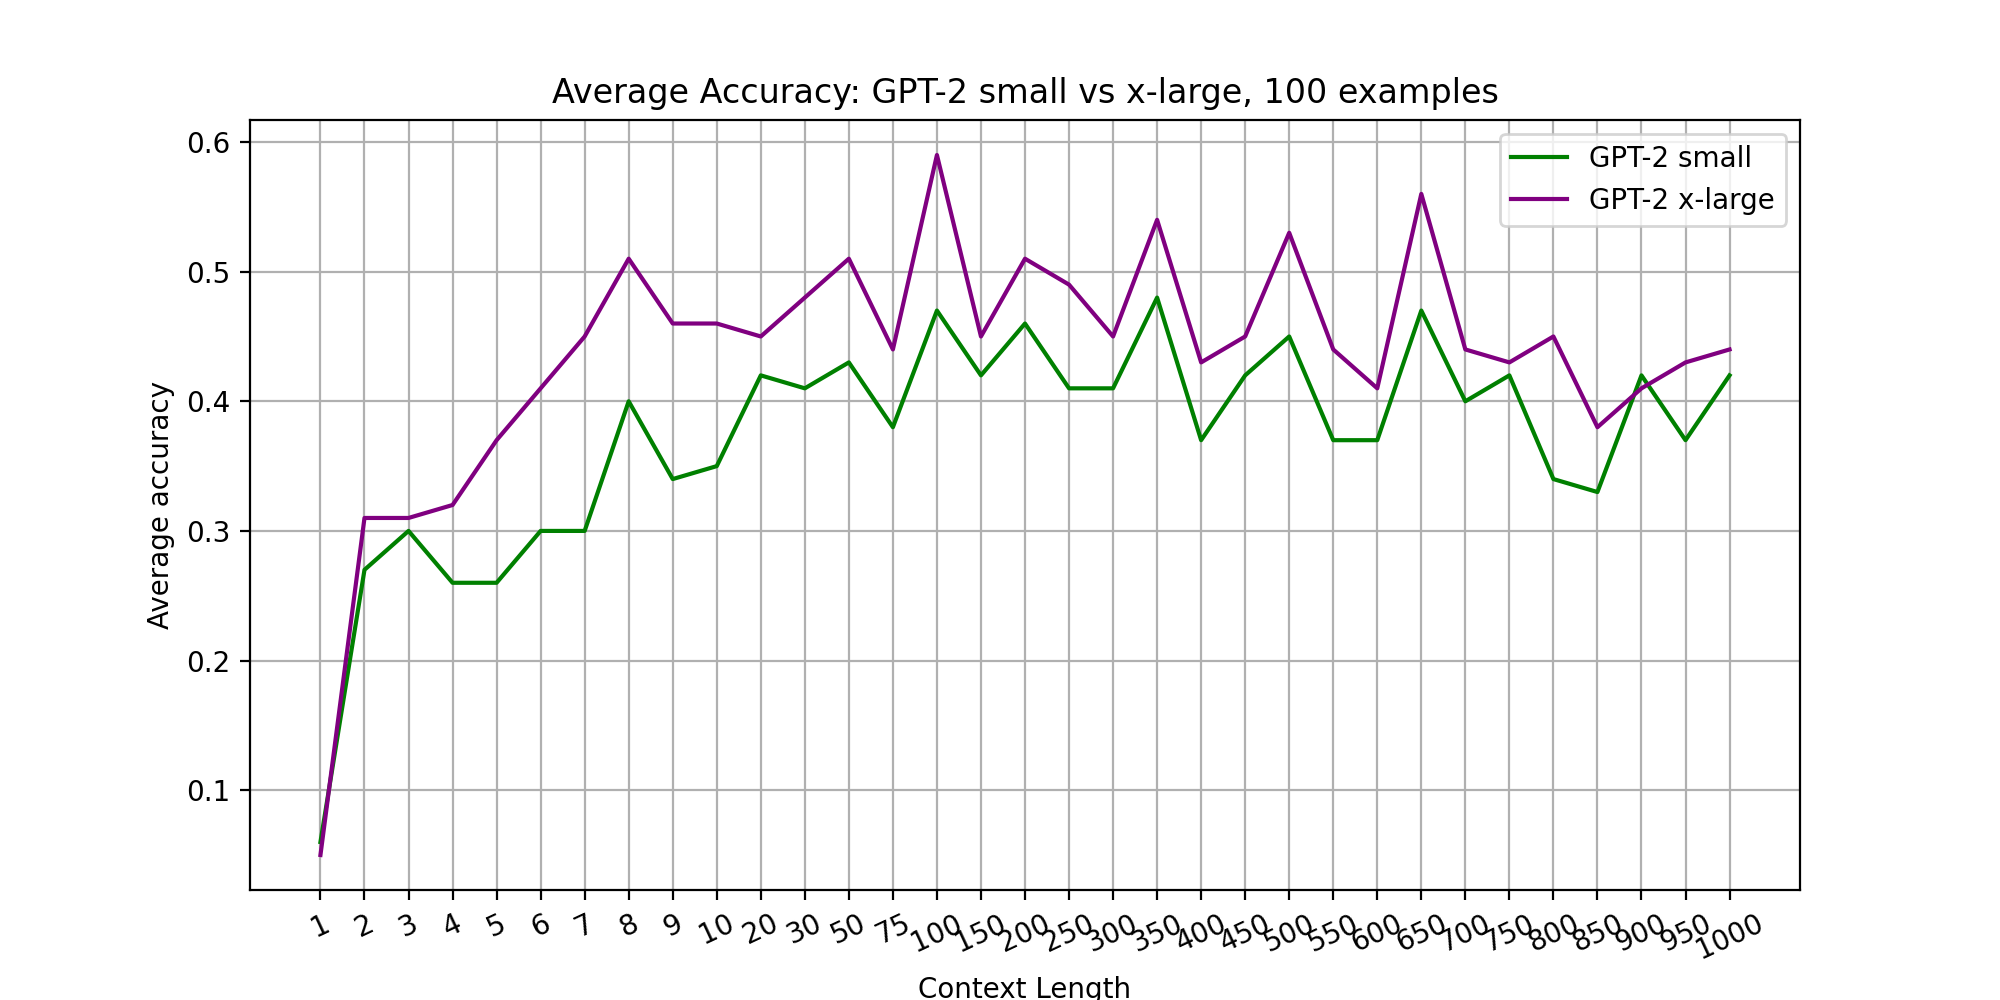

In [ ]:
with open("gpt2small_datav3_clv2.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav3_clv2.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_1 = list(acc_small)
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = list(acc_large)
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small", color='green')
plt.plot(x_2, y_2, label="GPT-2 x-large", color='purple')
plt.xticks(rotation = 25)
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large, 100 examples")
plt.grid()
plt.show()

##### GPT-2 small (49 ex vs 75 ex)

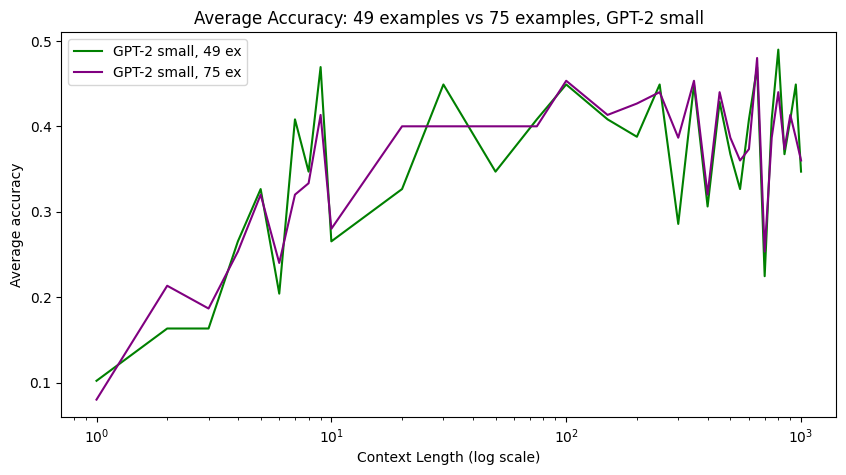

In [ ]:
with open("gpt2small_datav1_clv2.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2small_datav2_clv2.json") as f:
  content = f.read()
acc_small_data2 = json.loads(content)
x_1 = np.array(list(acc_small), dtype='float64')
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = np.array(list(acc_small_data2), dtype='float64')
y_2 = np.array(list(acc_small_data2.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small, 49 ex", color='green')
plt.plot(x_2, y_2, label="GPT-2 small, 75 ex", color='purple')
plt.xscale('log')
plt.legend()
plt.xlabel("Context Length (log scale)")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: 49 examples vs 75 examples, GPT-2 small")
plt.show()

##### GPT-2 x-large (45 ex vs 75 ex)

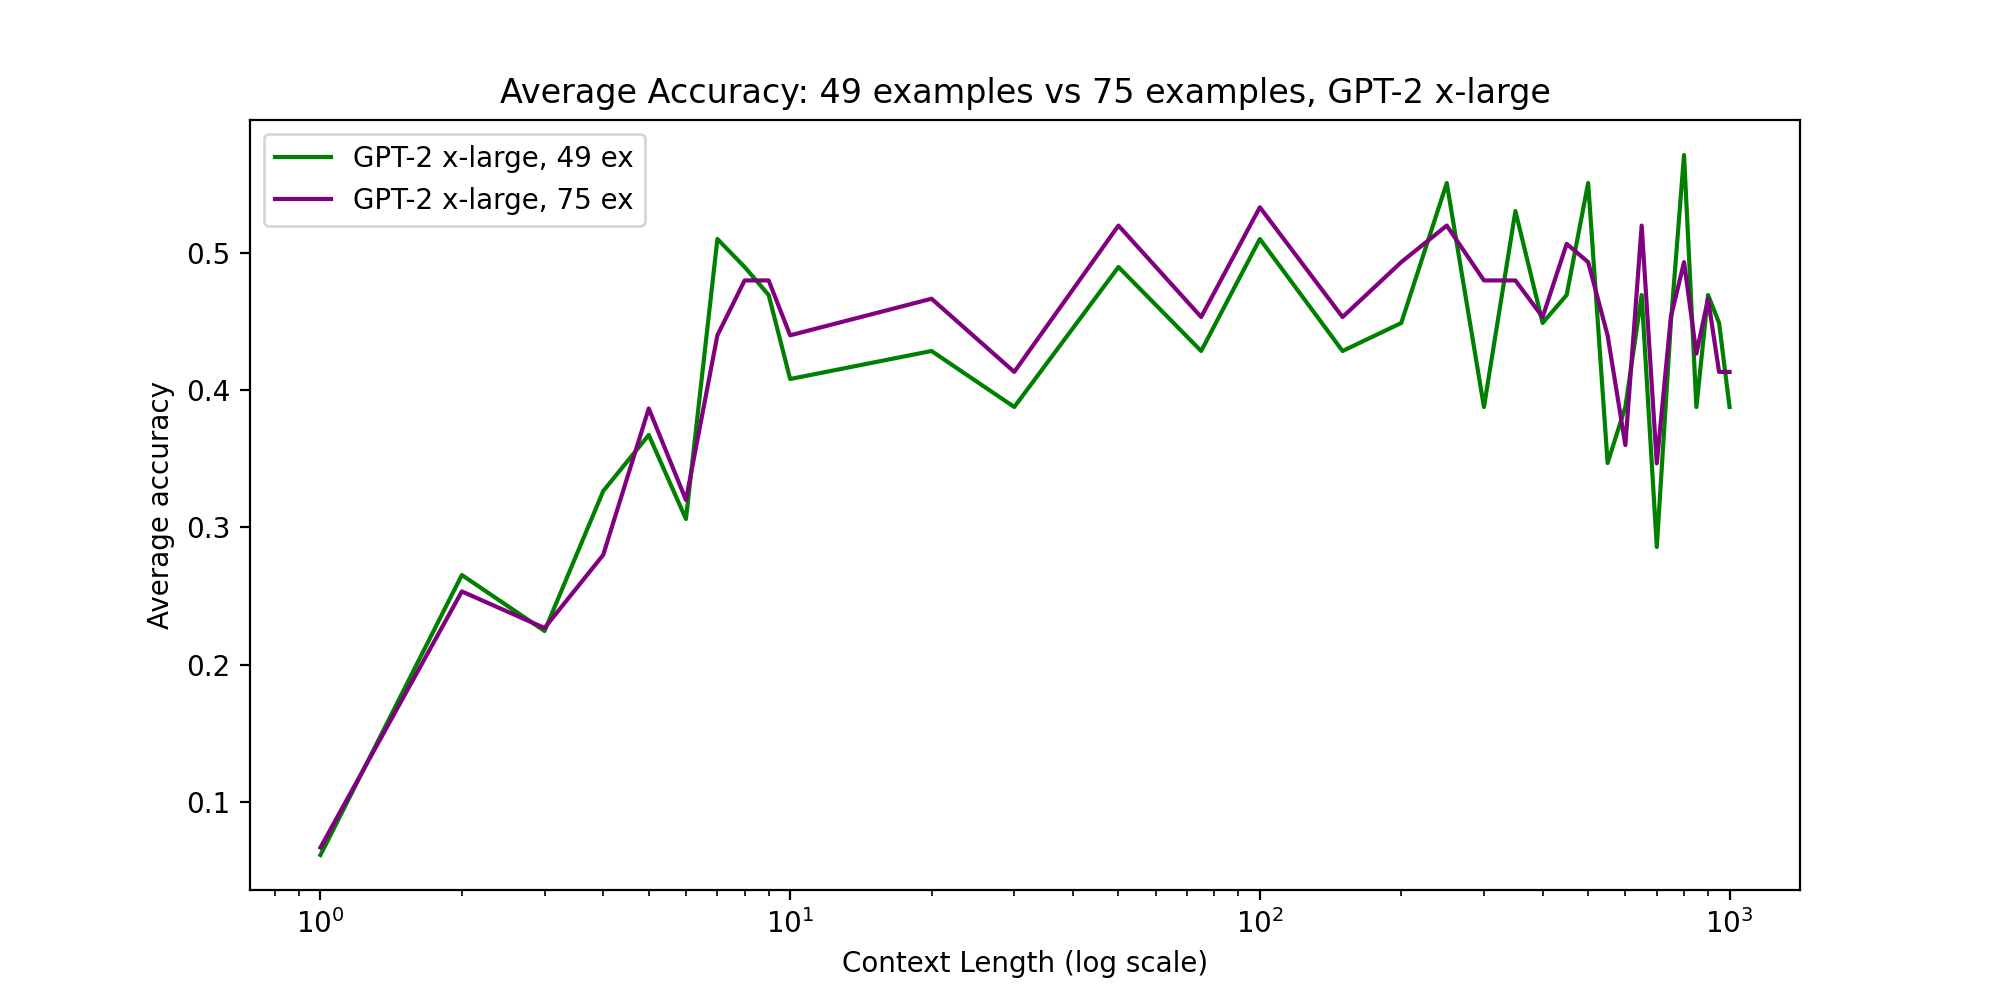

In [ ]:
with open("gpt2large_datav1_clv2.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav2_clv2.json") as f:
  content = f.read()
acc_small_data2 = json.loads(content)
x_1 = np.array(list(acc_small), dtype='float64')
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = np.array(list(acc_small_data2), dtype='float64')
y_2 = np.array(list(acc_small_data2.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 x-large, 49 ex", color='green')
plt.plot(x_2, y_2, label="GPT-2 x-large, 75 ex", color='purple')
plt.xscale('log')
plt.legend()
plt.xlabel("Context Length (log scale)")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: 49 examples vs 75 examples, GPT-2 x-large")
plt.show()

In [ ]:
##### GPT-2 x-large (45 ex vs 75 ex vs 100 ex)

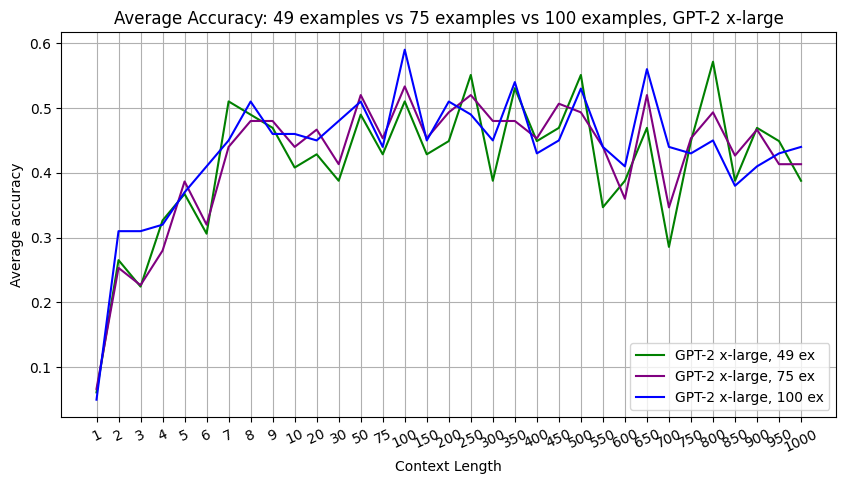

In [18]:
with open("gpt2large_datav1_clv2.json") as f:
  content = f.read()
acc_large = json.loads(content)
with open("gpt2large_datav2_clv2.json") as f:
  content = f.read()
acc_large_data2 = json.loads(content)
with open("gpt2large_datav3_clv2.json") as f:
  content = f.read()
acc_large_data3 = json.loads(content)
x_1 = list(acc_large)
x_2 = list(acc_large_data2)
x_3 = list(acc_large_data3)
y_1 = np.array(list(acc_large.values()), dtype='float64')
y_2 = np.array(list(acc_large_data2.values()), dtype='float64')
y_3 = np.array(list(acc_large_data3.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 x-large, 49 ex", color='green')
plt.plot(x_2, y_2, label="GPT-2 x-large, 75 ex", color='purple')
plt.plot(x_3, y_3, label="GPT-2 x-large, 100 ex", color='blue')
#plt.xscale('log')
plt.xticks(rotation = 25)
plt.legend()
plt.grid()
plt.xlabel("Context Length")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: 49 examples vs 75 examples vs 100 examples, GPT-2 x-large")
plt.show()

##### GPT-2 x-large (top 1 vs top 2 vs top top 3 vs top 4)

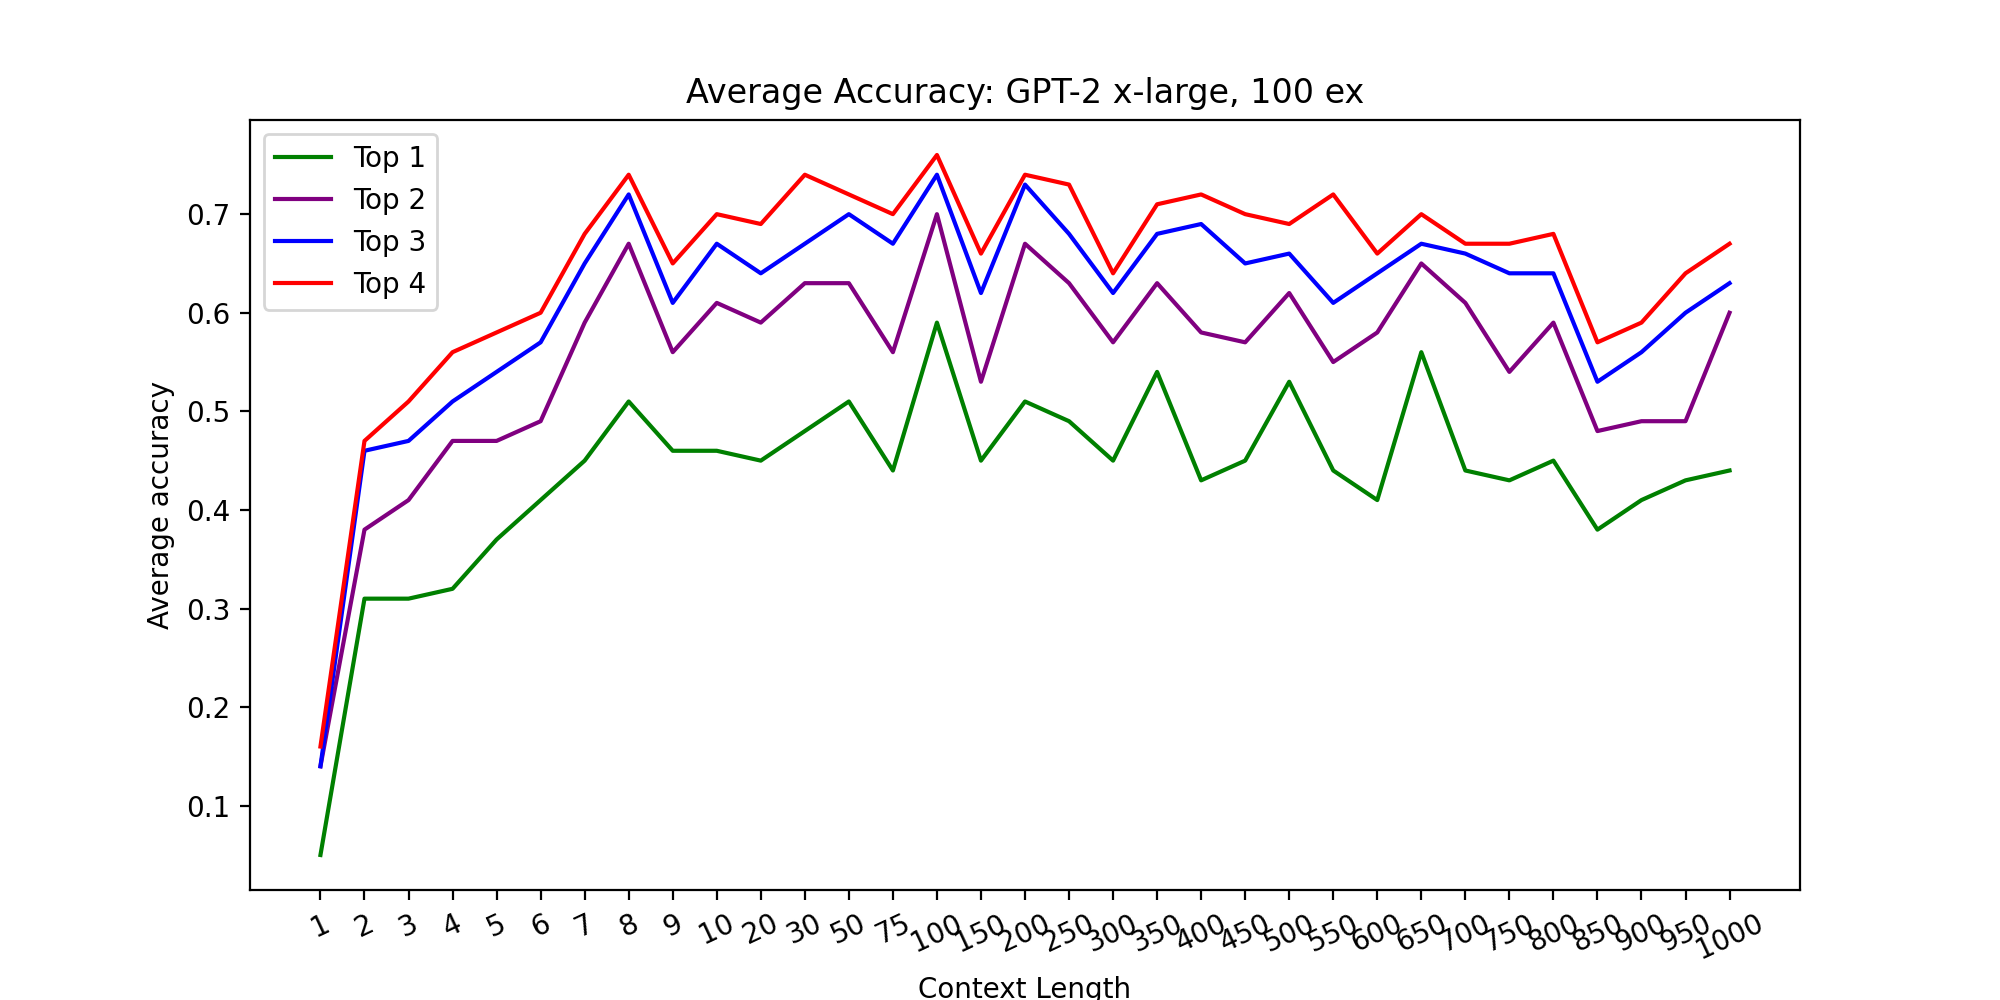

In [ ]:
with open("gpt2large_datav3_clv2.json") as f:
  content = f.read()
top1 = json.loads(content)
with open("gpt2large_datav3_clv2_top2.json") as f:
  content = f.read()
top2 = json.loads(content)
with open("gpt2large_datav3_clv2_top3.json") as f:
  content = f.read()
top3 = json.loads(content)
with open("gpt2large_datav3_clv2_top4.json") as f:
  content = f.read()
top4 = json.loads(content)
x_1 = list(top1)
y_1 = np.array(list(top1.values()), dtype='float64')
x_2 = list(top2)
y_2 = np.array(list(top2.values()), dtype='float64')
x_3 = list(top3)
y_3 = np.array(list(top3.values()), dtype='float64')
x_4 = list(top4)
y_4 = np.array(list(top4.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="Top 1", color='green')
plt.plot(x_2, y_2, label="Top 2", color='purple')
plt.plot(x_3, y_3, label="Top 3", color='blue')
plt.plot(x_4, y_4, label="Top 4", color='red')
plt.xticks(rotation = 25)
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 x-large, 100 ex")
plt.show()

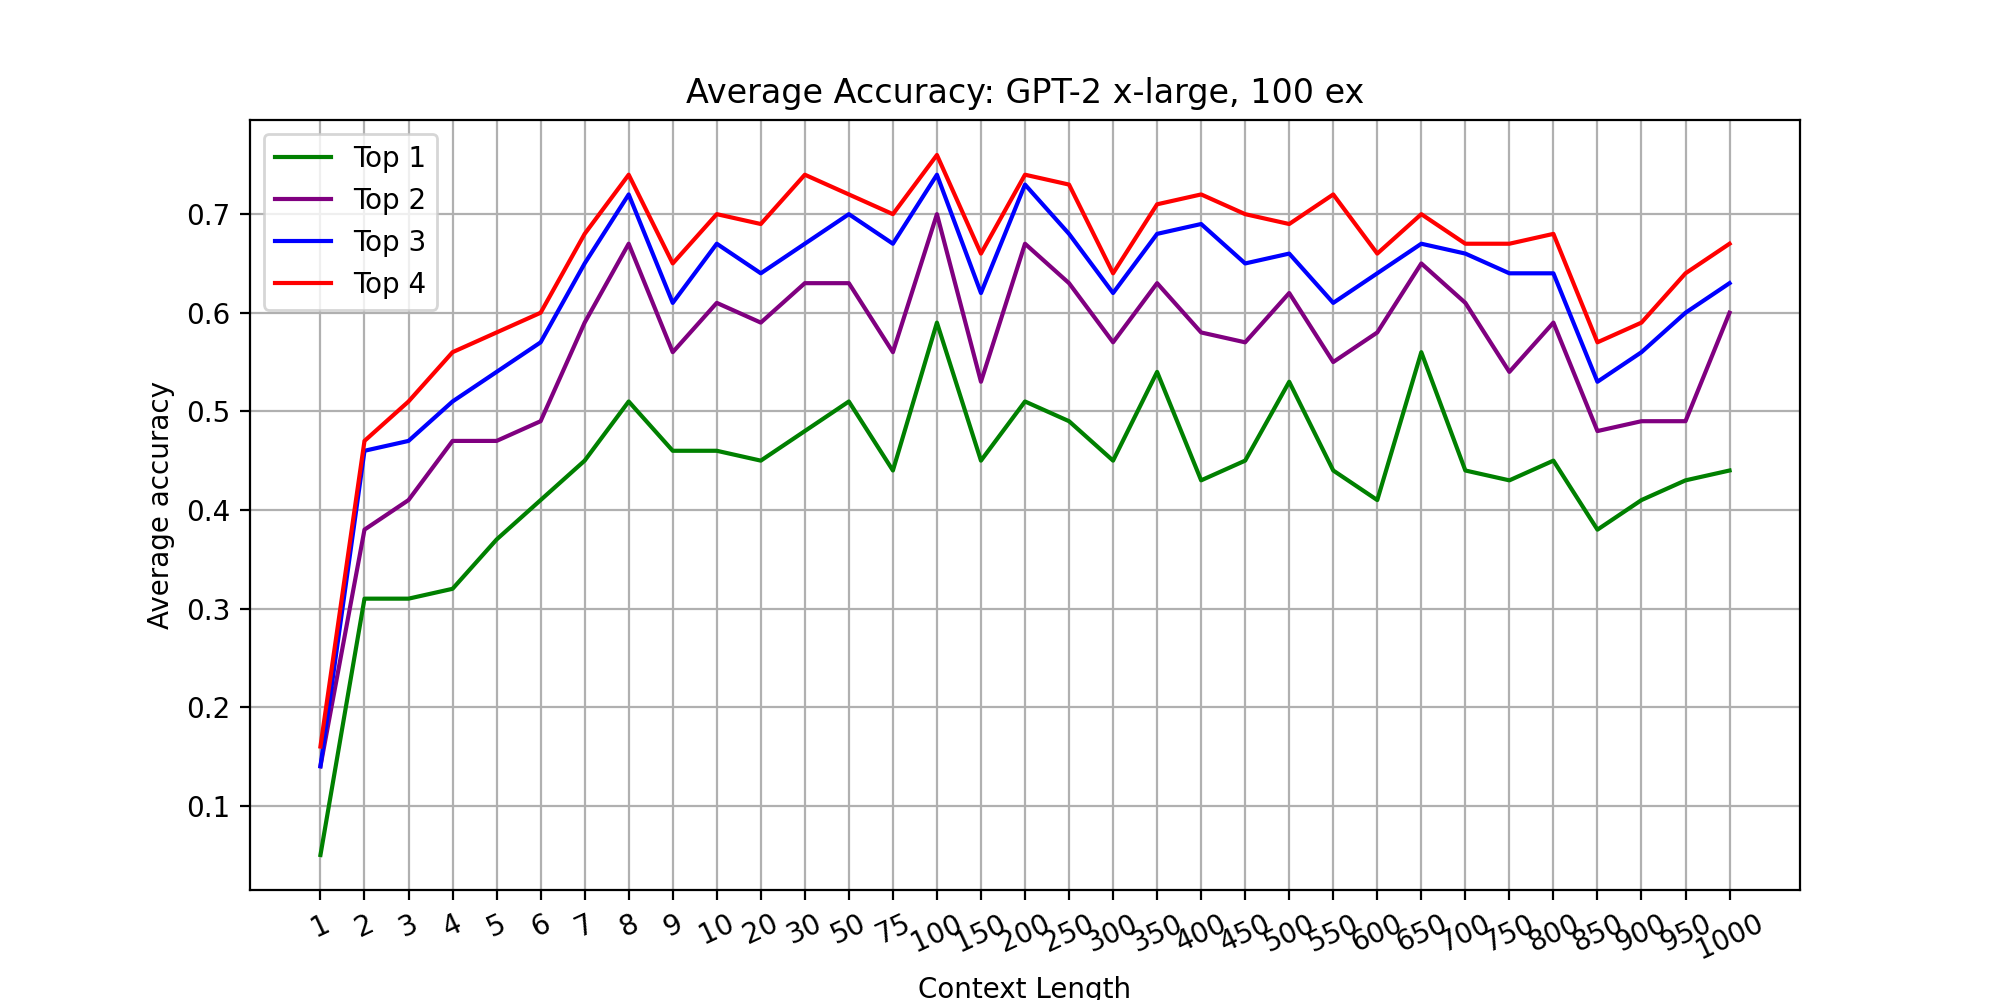

In [ ]:
with open("gpt2large_datav3_clv2.json") as f:
  content = f.read()
top1 = json.loads(content)
with open("gpt2large_datav3_clv2_top2.json") as f:
  content = f.read()
top2 = json.loads(content)
with open("gpt2large_datav3_clv2_top3.json") as f:
  content = f.read()
top3 = json.loads(content)
with open("gpt2large_datav3_clv2_top4.json") as f:
  content = f.read()
top4 = json.loads(content)
x_1 = list(top1)
y_1 = np.array(list(top1.values()), dtype='float64')
x_2 = list(top2)
y_2 = np.array(list(top2.values()), dtype='float64')
x_3 = list(top3)
y_3 = np.array(list(top3.values()), dtype='float64')
x_4 = list(top4)
y_4 = np.array(list(top4.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="Top 1", color='green')
plt.plot(x_2, y_2, label="Top 2", color='purple')
plt.plot(x_3, y_3, label="Top 3", color='blue')
plt.plot(x_4, y_4, label="Top 4", color='red')
plt.xticks(rotation = 25)
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 x-large, 100 ex")
plt.grid()
plt.show()